In [380]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt
from trade_obj import *

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/EEM.csv')
df = misc.clean_df(df)
df = df.set_index('date')



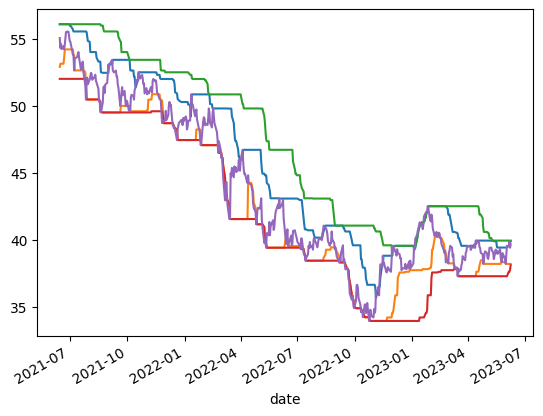

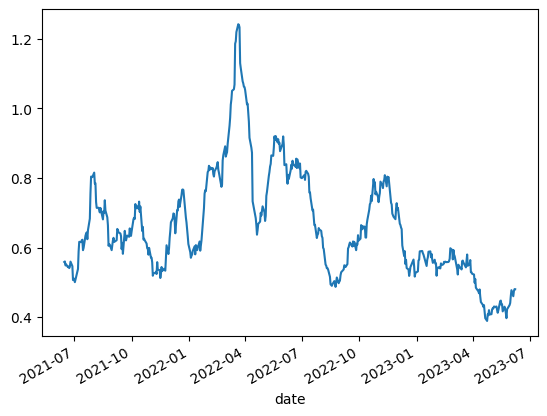

In [381]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()
df['55_up_bound'] = df['close'].shift(1).rolling(55).max()
df['55_low_bound'] = df['close'].shift(1).rolling(55).min()



df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


df1 = df[-500:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['55_up_bound'].plot()
df1['55_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [382]:
bt = backTester()
df = df.dropna()
# df = df[-1000:]
bt.set_asset(df)

upbound20 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound10 = df['10_low_bound'].to_numpy()
upbound55 = df['55_up_bound'].to_numpy()
lowbound55 = df['55_low_bound'].to_numpy()
atr = df['ATR'].to_numpy()

stop_loss_arr = []
stop_loss = np.nan

tl = tradeList()
last_trade_win = False
open_trade = None
open_trade55 = None


for i in range(len(bt.df)):
    
    order_quantity = 0
    order_price = 0
    n = atr[i]
    # risk_unit = int(bt.portfolio_value * 0.02 / (3 * n))
    risk_unit = bt.cash // bt.high[i]
    

    # no open trades
    if open_trade == None:
        # breakout from 20 day high
        if bt.high[i] > upbound20[i]:
            # print(f'--- index {i}, date: {bt.date[i]} ---')
            # print(f'high: {bt.high[i]} > long breakout: {upbound20[i]}')
            long_entry_price = upbound20[i]
            # calculate stop_loss
            stop_loss = long_entry_price - 3 * n
            
            # if not last_trade_win:
            if True:
                
                # order price at breakout
                order_price = long_entry_price
                # order 1 unit
                order_quantity = risk_unit
                
                # open trade on record
                open_trade = trade(bt.date[i], order_price, order_quantity, type='long20')
                # print(f'entry price: {order_price}, quantity: {order_quantity}')

            else:
                long_entry_price = upbound20[i]
                # print('last trade was profitable: fake trade')
                open_trade = fakeTrade(1)

            

    # open trades present 
    else:
        # if open trades are long
        if open_trade.quantity > 0:
            pass
            # calculate trailing stop_loss
            stop_loss = max(stop_loss, bt.high[i] - 3 * n)
            # print(f'stop_loss {stop_loss}')
            # print(f'lowbound10 {lowbound10[i]}')
            # combine low bound 10 and trailing stop loss
            stop_loss = max(stop_loss, lowbound10[i])
            

            # exit trade if stop loss is triggered
            if bt.low[i] < stop_loss:
                if open_trade.type == 'fake':
                    # close fake trade
                    last_trade_win = True if stop_loss > long_entry_price else False
                else:
                    # print(f'--- index {i}, date: {bt.date[i]} ---')
                    # print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                    # exit price at stoploss
                    order_price = stop_loss
                    order_quantity = -open_trade.quantity
                        
                    open_trade.close(bt.date[i], order_price)
                    tl.append(open_trade)
                    if order_price < long_entry_price:
                        last_trade_win = -1
                    else:
                        last_trade_win = 1
                    entry_exit = order_price
                
                open_trade = None
                stop_loss = np.nan
    
    


        
    stop_loss_arr.append(stop_loss)

    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            

df['stop_loss'] = stop_loss_arr


df['entry_price'] = np.nan
df['exit_price'] = np.nan
df['entry_price'] = np.nan
df['exit_price'] = np.nan
for t in tl.list:

    for i in range(len(t.entry_date)):
        df.loc[df.index == t.entry_date[i], 'entry_price'] = t.entry_price[i]
        
    df.loc[df.index == t.exit_date, 'exit_price'] = t.exit_price



end


In [383]:
print(len(bt.date))

5000


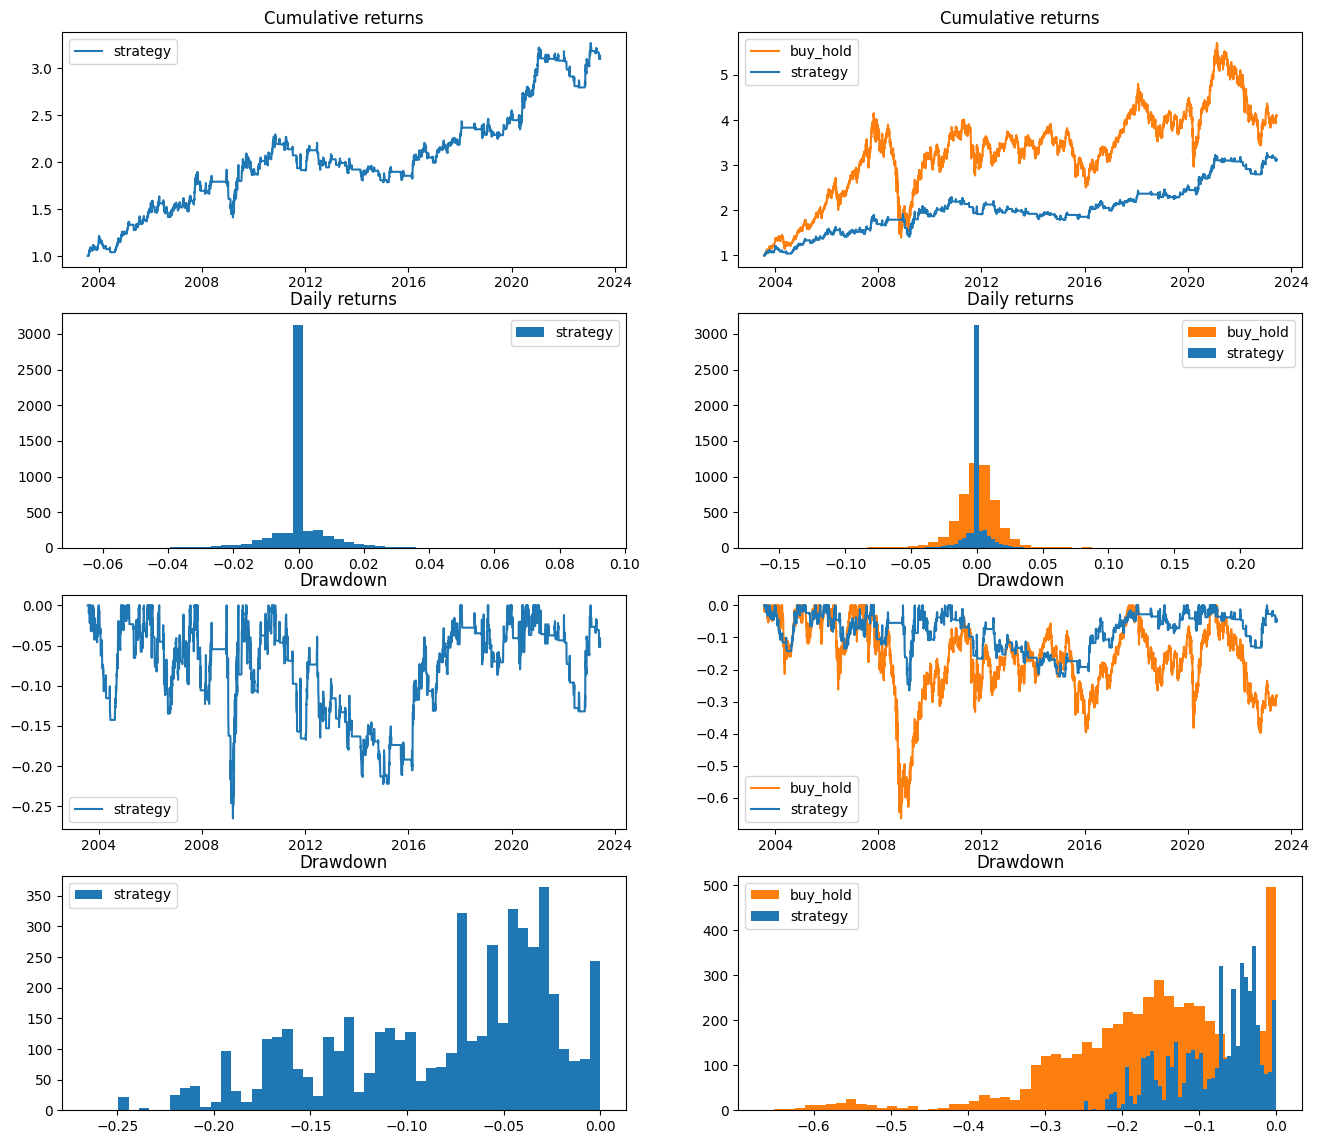

In [384]:
bt.analyse()
bt.plot_graphs()

<Axes: xlabel='date'>

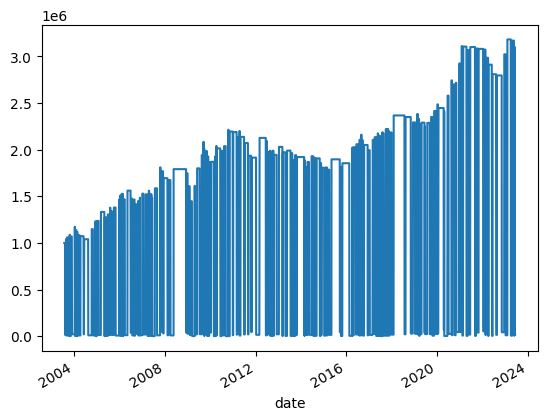

In [385]:
bt.records['cash'].plot()

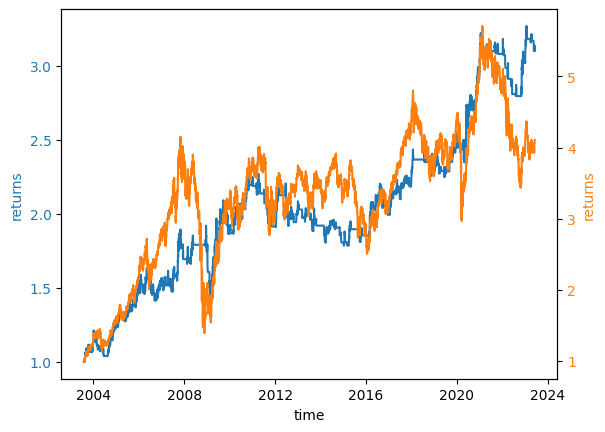

In [386]:

fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [387]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.058978287005651664
buy_hold annual return:     0.07374177216888511
Annualised vol:             0.1314650212414426
buy_hold annual vol:        0.282428720128674
Sharpe ratio:               0.44862341669830835
buy_hold Sharpe ratio:      0.2610987017725694


In [388]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 70,
 'num_loss': 80,
 'win_rate': 0.4666666666666667,
 'profit_total': 2101230.440395928,
 'profit_mean': 14008.202935972853,
 'returns_mean': 0.008503055053504098,
 'returns_std': 0.04236974232191427,
 'time_in_trade_mean': 19.293333333333333,
 'time_in_trade_std': 13.697864756283431,
 'capital_at_risk_mean': 1958971.5713517189,
 'win_returns_mean': 0.04419132103224564,
 'win_returns_std': 0.03319389170986803,
 'win_profit_mean': 80074.64817048349,
 'win_time_in_trade_mean': 29.271428571428572,
 'win_time_in_trade_std': 12.765353277775677,
 'loss_returns_mean': -0.022724177677894752,
 'loss_returns_std': 0.017534999230200677,
 'loss_profit_mean': -43799.93664422394,
 'loss_time_in_trade_mean': 10.5625,
 'loss_time_in_trade_std': 6.793227733410289}

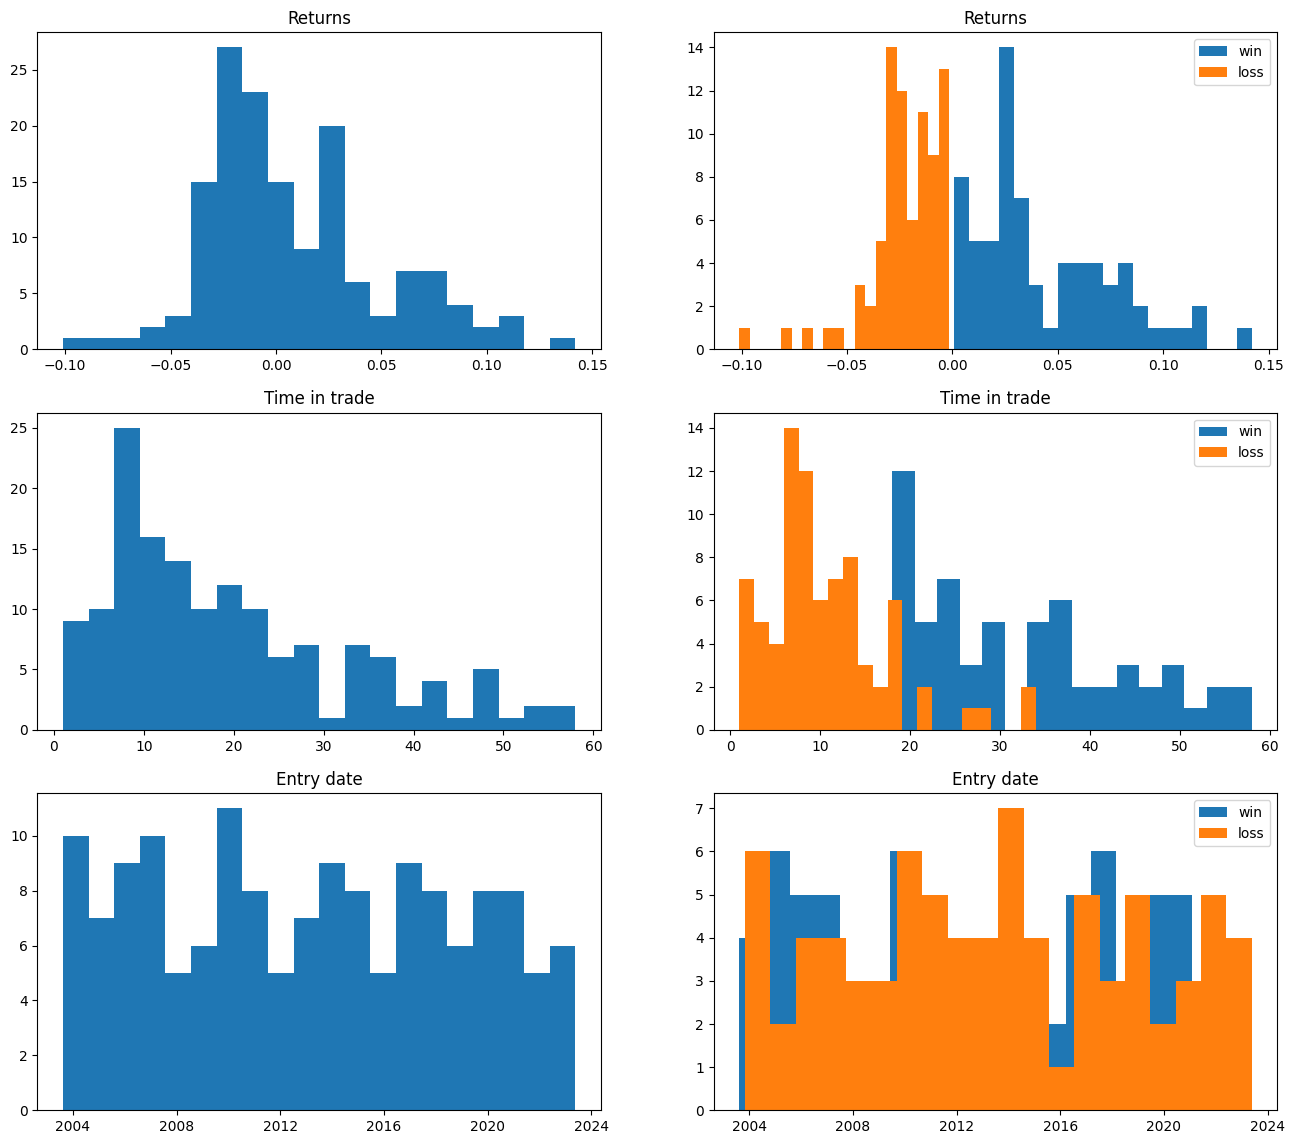

In [389]:
tl.plot_graphs()

trade 0
entry: [14.194443702697754]
cost_basis: 14.194443702697754
exit: 14.783222389221192
returns: 0.04147951824357421
10


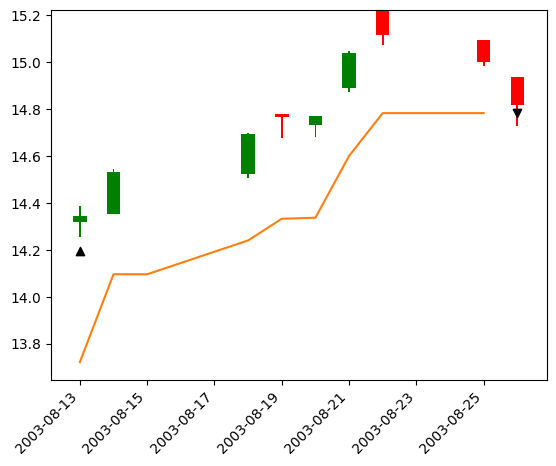

trade 1
entry: [15.117777824401855]
cost_basis: 15.117777824401855
exit: 15.3775559425354
returns: 0.017183617933201296
8


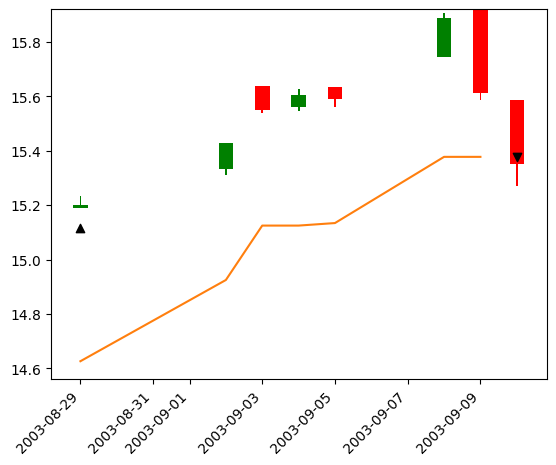

trade 2
entry: [15.886667251586914]
cost_basis: 15.886667251586914
exit: 16.311111450195312
returns: 0.02671700690187244
15


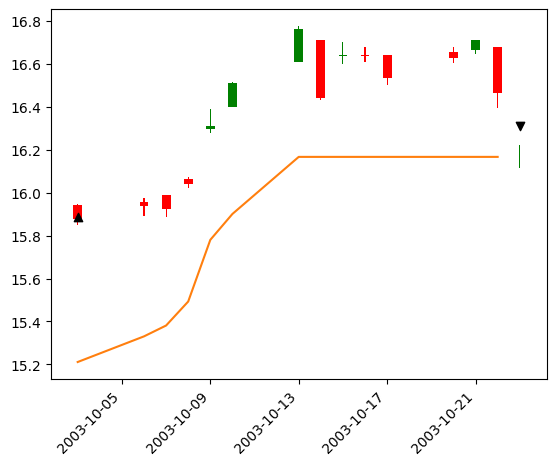

trade 3
entry: [16.761110305786133]
cost_basis: 16.761110305786133
exit: 16.489999771118164
returns: -0.016174974671837712
9


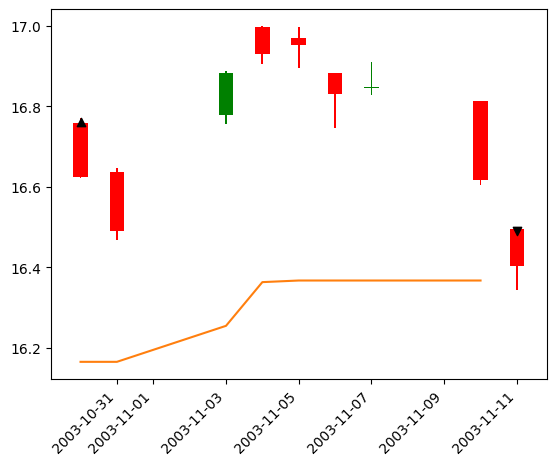

trade 4
entry: [16.95222282409668]
cost_basis: 16.95222282409668
exit: 18.631832599639893
returns: 0.09907902892567795
32


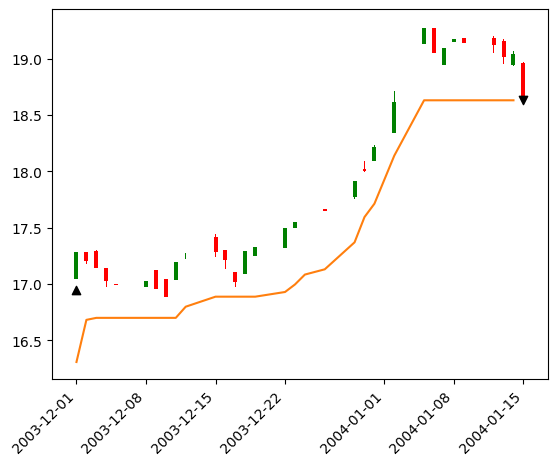

trade 5
entry: [19.273332595825195]
cost_basis: 19.273332595825195
exit: 18.679445266723633
returns: -0.030813940772765197
8


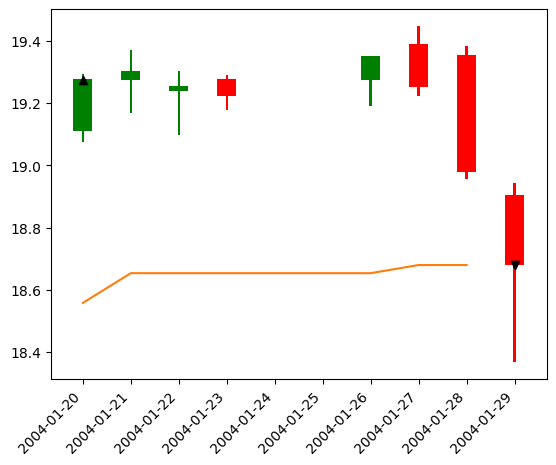

trade 6
entry: [19.350000381469727]
cost_basis: 19.350000381469727
exit: 19.02494583129883
returns: -0.016798684432181264
7


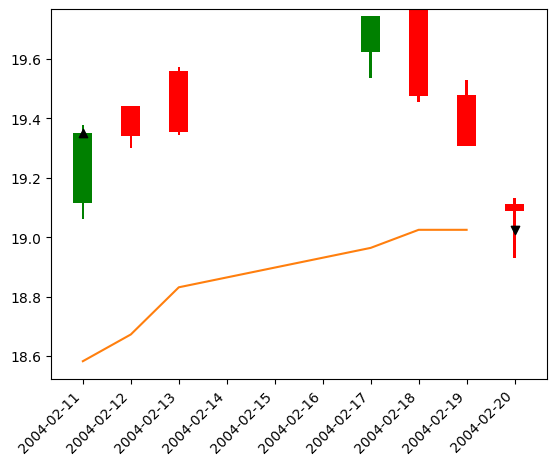

trade 7
entry: [19.744443893432617]
cost_basis: 19.744443893432617
exit: 19.12788896560669
returns: -0.03122675579791868
8


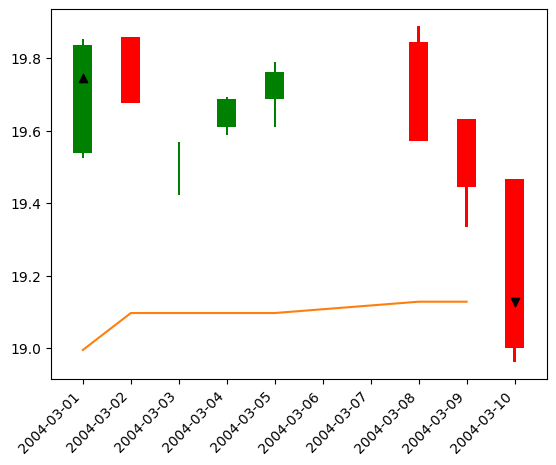

trade 8
entry: [19.761110305786133]
cost_basis: 19.761110305786133
exit: 19.56549978256226
returns: -0.009898761769807937
9


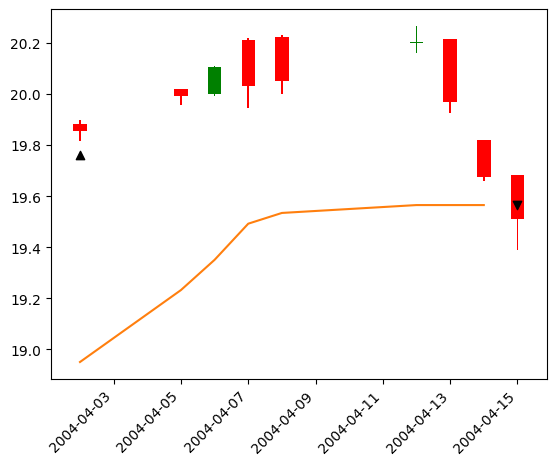

trade 9
entry: [17.833332061767578]
cost_basis: 17.833332061767578
exit: 17.278888702392578
returns: -0.03109028405093498
5


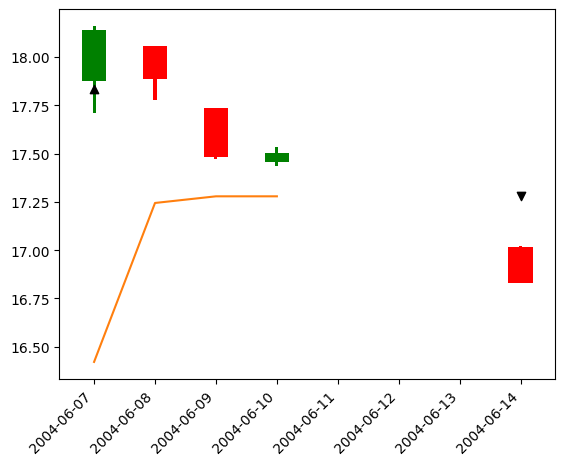

trade 10
entry: [17.422222137451172]
cost_basis: 17.422222137451172
exit: 19.247445487976076
returns: 0.10476409588426532
40


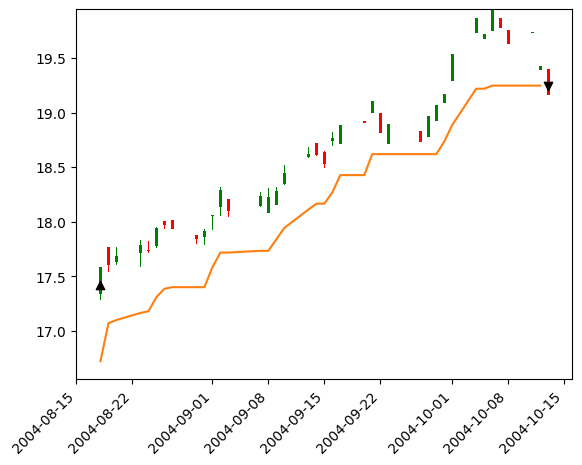

trade 11
entry: [19.947778701782227]
cost_basis: 19.947778701782227
exit: 21.41111183166504
returns: 0.07335819951481974
27


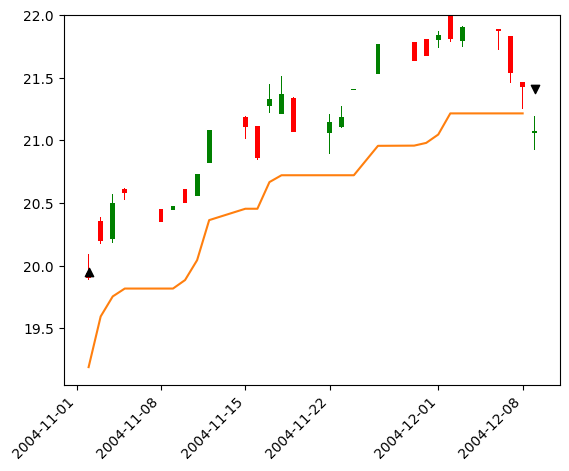

trade 12
entry: [21.905555725097656]
cost_basis: 21.905555725097656
exit: 21.994443893432617
returns: 0.004057791066816894
13


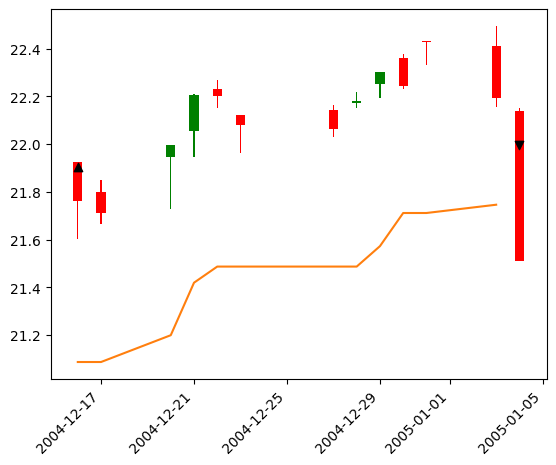

trade 13
entry: [22.30888938903809]
cost_basis: 22.30888938903809
exit: 24.06666755676269
returns: 0.07879272415005657
27


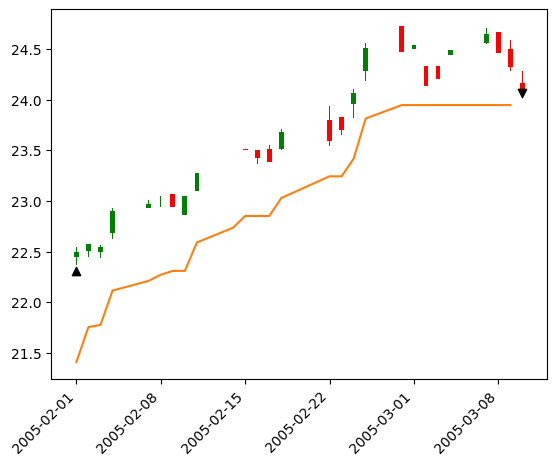

trade 14
entry: [23.254444122314453]
cost_basis: 23.254444122314453
exit: 22.252222061157227
returns: -0.043098087225207686
7


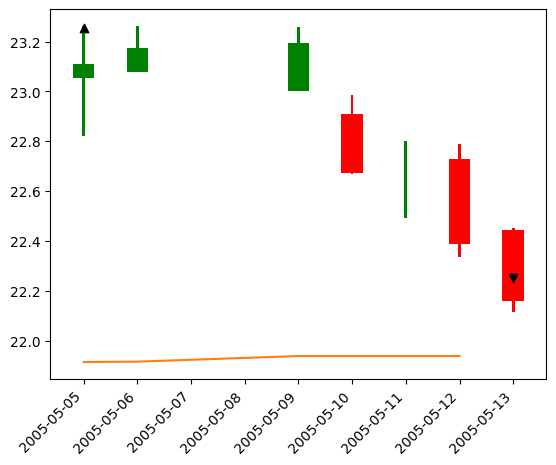

trade 15
entry: [23.19333267211914]
cost_basis: 23.19333267211914
exit: 23.75
returns: 0.024001178948725763
22


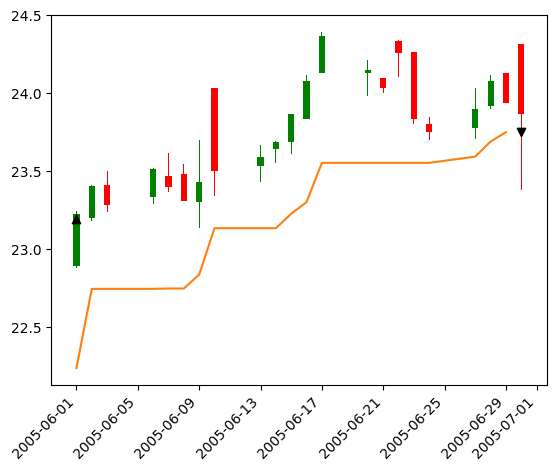

trade 16
entry: [24.3700008392334]
cost_basis: 24.3700008392334
exit: 25.733333683013914
returns: 0.055943077424342076
20


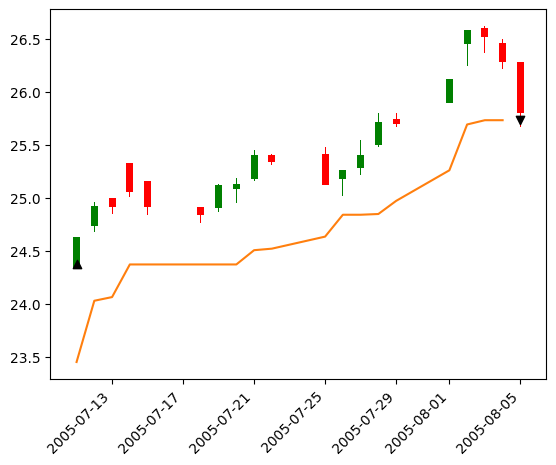

trade 17
entry: [26.583332061767575]
cost_basis: 26.583332061767575
exit: 25.859000968933106
returns: -0.02724756592407048
7


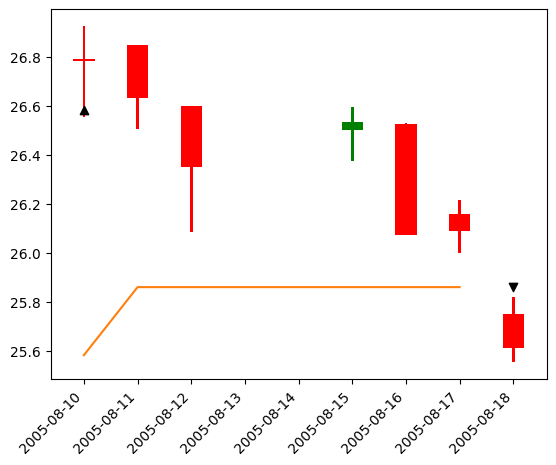

trade 18
entry: [26.78333282470703]
cost_basis: 26.78333282470703
exit: 27.567999553680423
returns: 0.02929682926725063
22


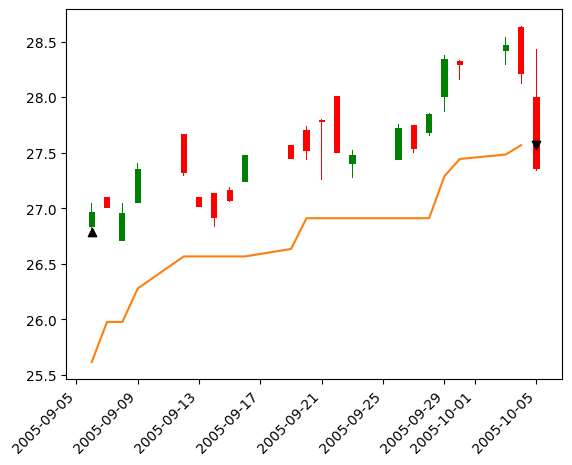

trade 19
entry: [27.350000381469727]
cost_basis: 27.350000381469727
exit: 29.100000381469727
returns: 0.06398537387903169
41


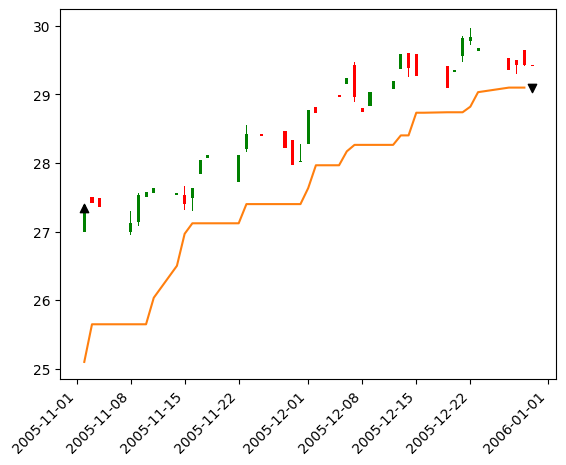

trade 20
entry: [29.833332061767575]
cost_basis: 29.833332061767575
exit: 30.70199966430664
returns: 0.029117351046827684
11


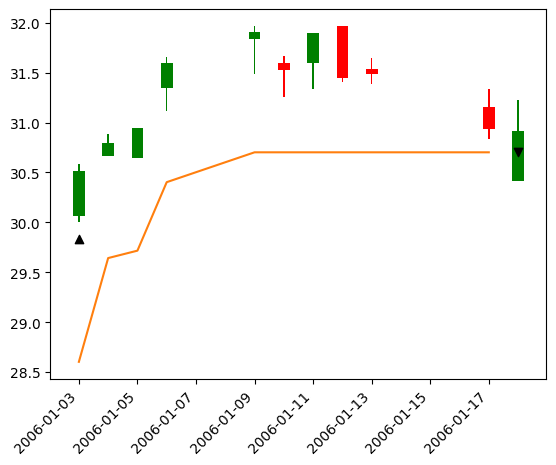

trade 21
entry: [31.906667709350582]
cost_basis: 31.906667709350582
exit: 32.26666641235352
returns: 0.011282867464640908
14


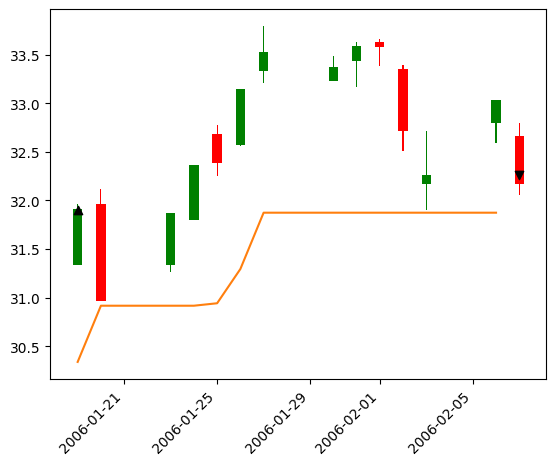

trade 22
entry: [33.59333419799805]
cost_basis: 33.59333419799805
exit: 32.29999923706055
returns: -0.03849974978115077
4


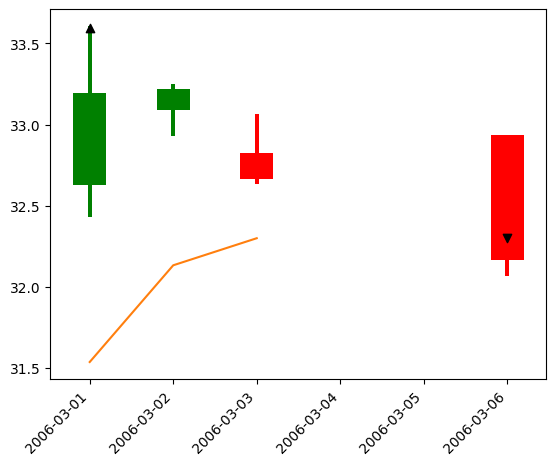

trade 23
entry: [33.220001220703125]
cost_basis: 33.220001220703125
exit: 35.34633312225342
returns: 0.06400758047609996
31


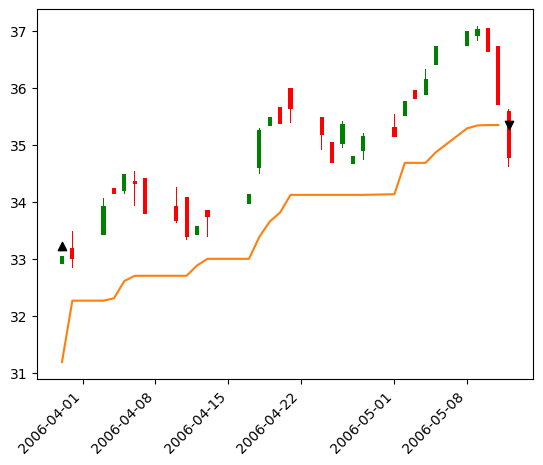

trade 24
entry: [31.299999237060547]
cost_basis: 31.299999237060547
exit: 29.51666641235352
returns: -0.056975490996034425
9


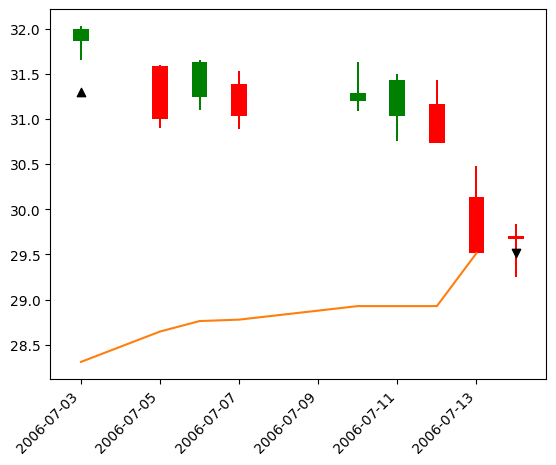

trade 25
entry: [31.99333381652832]
cost_basis: 31.99333381652832
exit: 31.82333374023437
returns: -0.005313609305889961
21


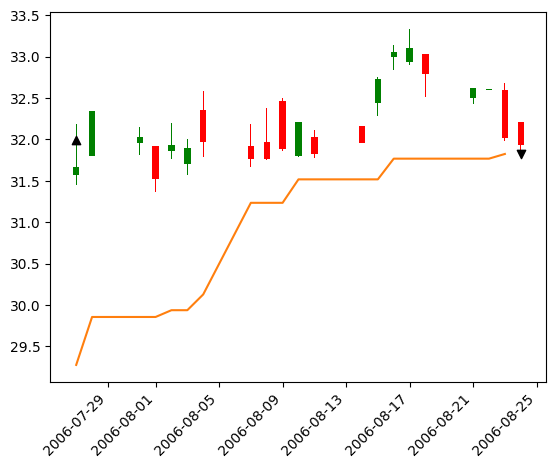

trade 26
entry: [33.099998474121094]
cost_basis: 33.099998474121094
exit: 31.93000030517578
returns: -0.035347378334777385
3


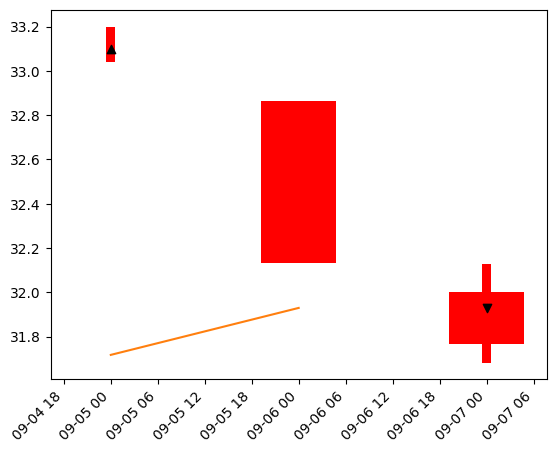

trade 27
entry: [32.793331146240234]
cost_basis: 32.793331146240234
exit: 33.61333465576172
returns: 0.0250051910208426
18


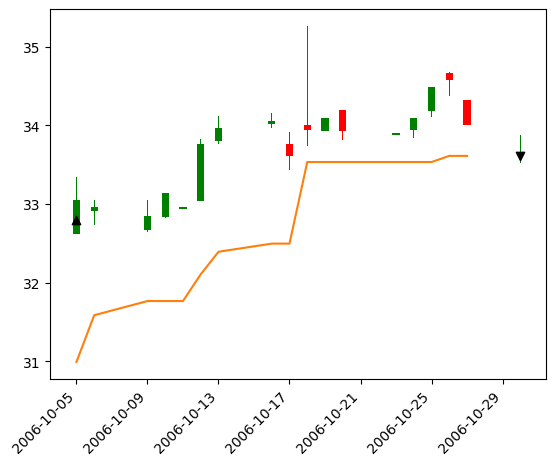

trade 28
entry: [34.57666778564453]
cost_basis: 34.57666778564453
exit: 35.4466667175293
returns: 0.02516144520571673
19


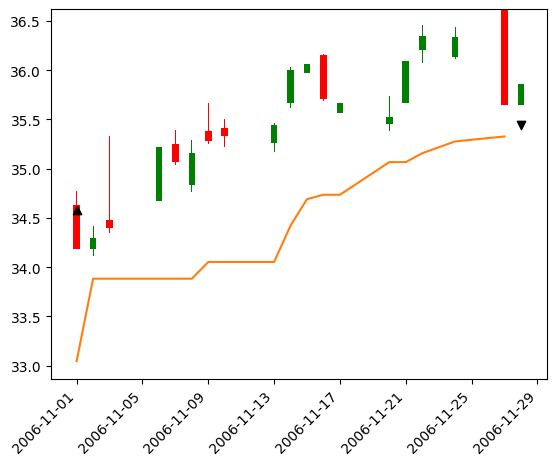

trade 29
entry: [36.34333419799805]
cost_basis: 36.34333419799805
exit: 37.400332832336424
returns: 0.029083700151996558
25


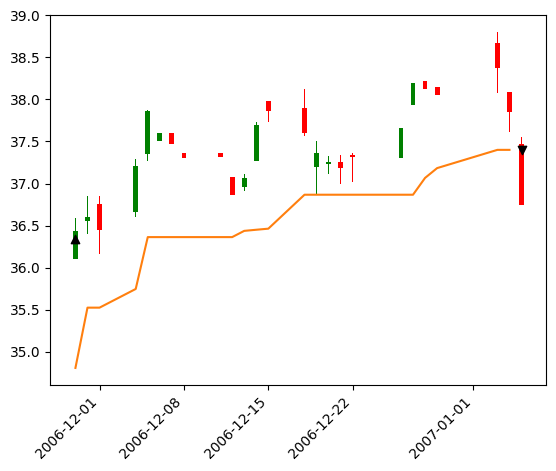

trade 30
entry: [38.380001068115234]
cost_basis: 38.380001068115234
exit: 38.179499816894534
returns: -0.00522410749454798
24


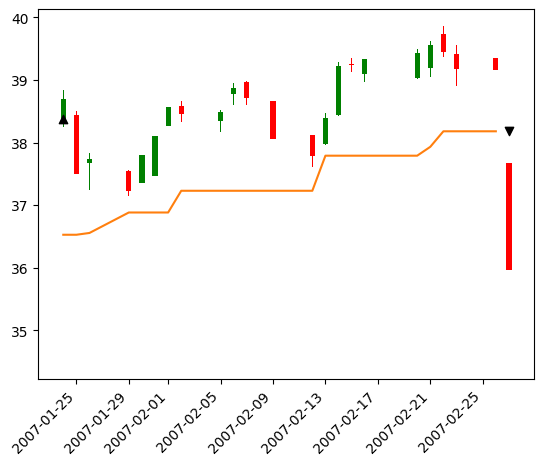

trade 31
entry: [38.973331451416016]
cost_basis: 38.973331451416016
exit: 39.9900016784668
returns: 0.026086305409075892
14


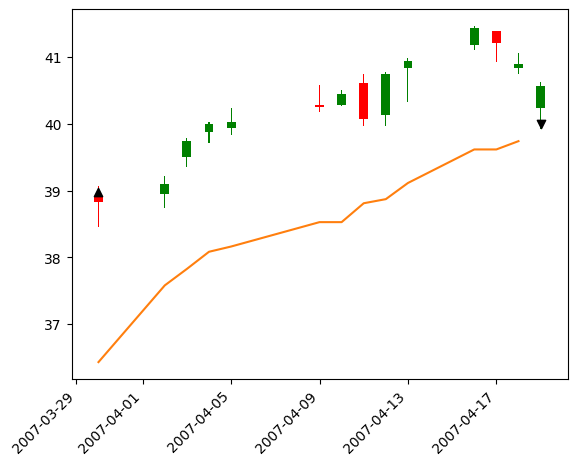

trade 32
entry: [41.43000030517578]
cost_basis: 41.43000030517578
exit: 40.56999969482422
returns: -0.02075791947904292
3


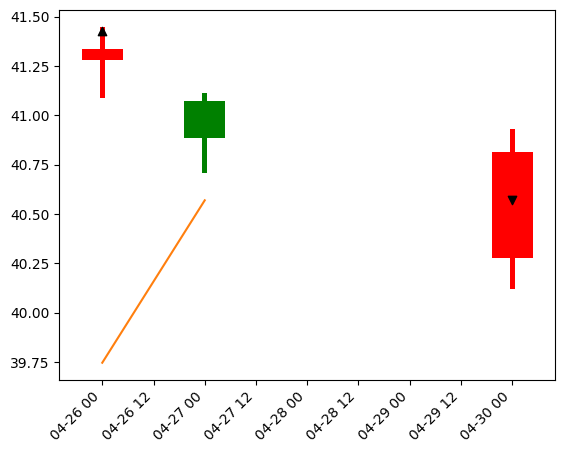

trade 33
entry: [41.43000030517578]
cost_basis: 41.43000030517578
exit: 41.28333282470703
returns: -0.0035401274291187268
19


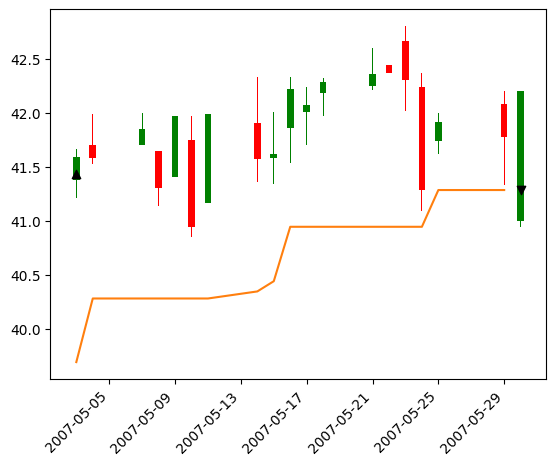

trade 34
entry: [42.36666870117188]
cost_basis: 42.36666870117188
exit: 41.28333282470703
returns: -0.025570475793271073
6


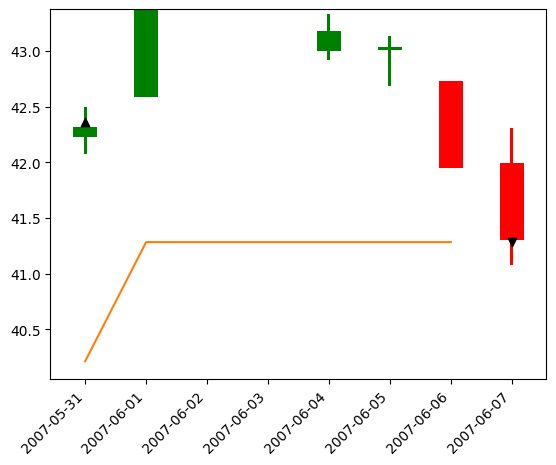

trade 35
entry: [43.37666702270508]
cost_basis: 43.37666702270508
exit: 46.36666870117188
returns: 0.06893110706043223
30


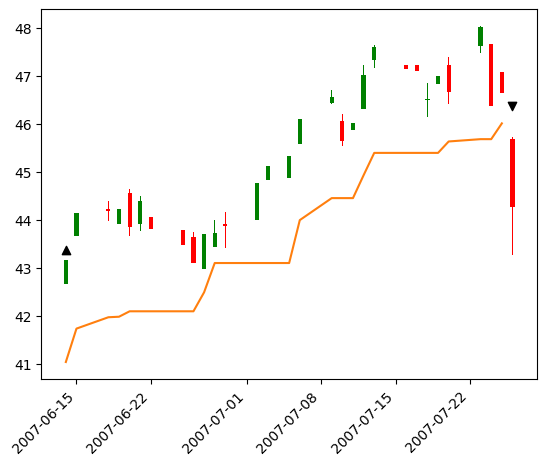

trade 36
entry: [45.133331298828125]
cost_basis: 45.133331298828125
exit: 51.54333114624024
returns: 0.14202363669926024
35


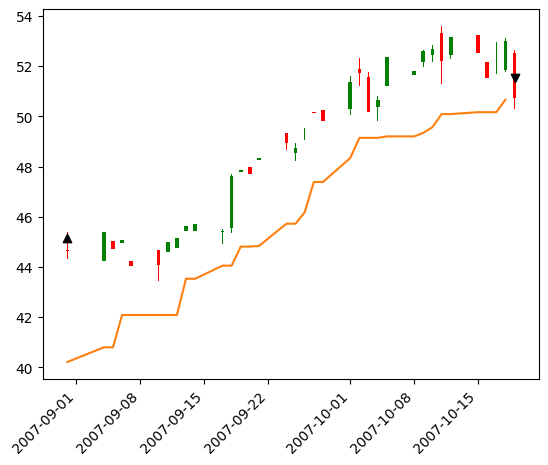

trade 37
entry: [53.16666793823242]
cost_basis: 53.16666793823242
exit: 51.913333892822266
returns: -0.023573680541090998
9


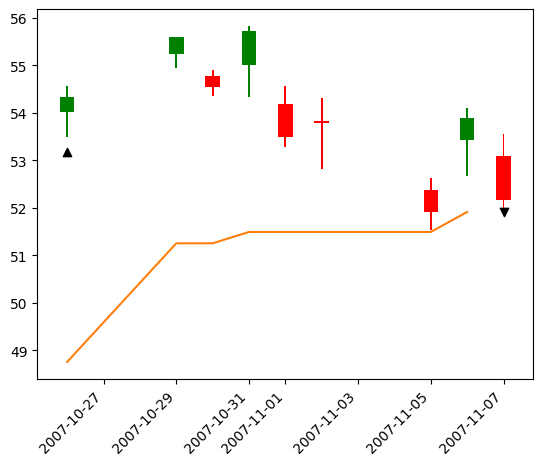

trade 38
entry: [53.14666748046875]
cost_basis: 53.14666748046875
exit: 50.88666534423828
returns: -0.04252387296082136
6


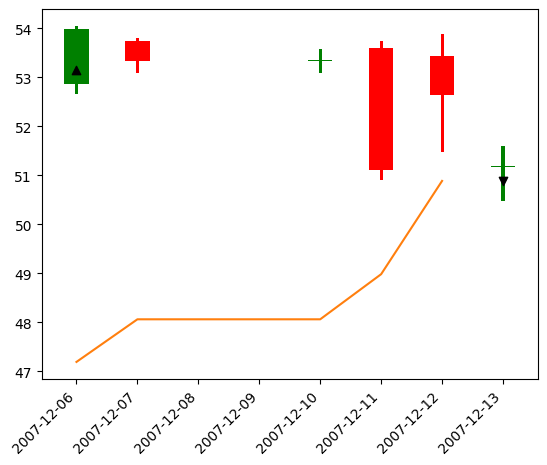

trade 39
entry: [46.68333435058594]
cost_basis: 46.68333435058594
exit: 46.11666870117188
returns: -0.01213849990145237
12


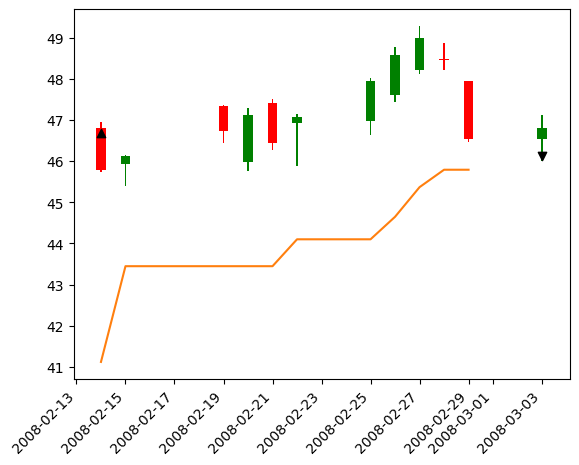

trade 40
entry: [46.66666793823242]
cost_basis: 46.66666793823242
exit: 49.960168075561526
returns: 0.07057500101975037
38


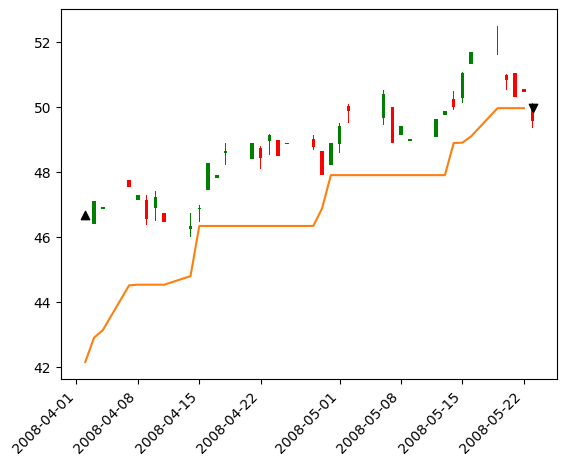

trade 41
entry: [24.57999992370605]
cost_basis: 24.57999992370605
exit: 23.950000762939453
returns: -0.025630559915461947
11


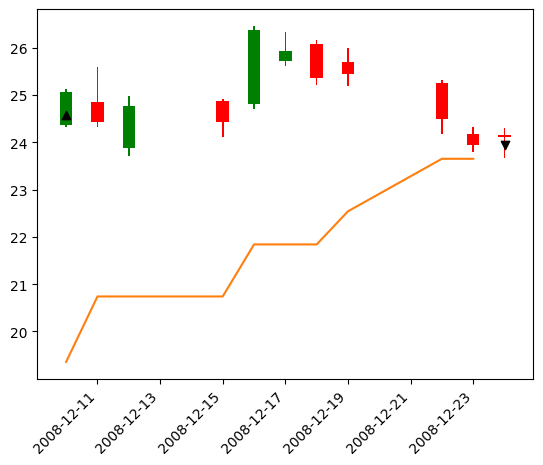

trade 42
entry: [26.3799991607666]
cost_basis: 26.3799991607666
exit: 24.259001636505126
returns: -0.08040172826904063
6


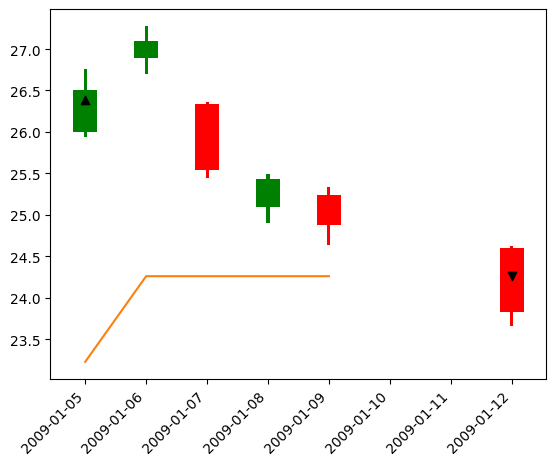

trade 43
entry: [24.940000534057617]
cost_basis: 24.940000534057617
exit: 22.420000076293945
returns: -0.10104251819571554
6


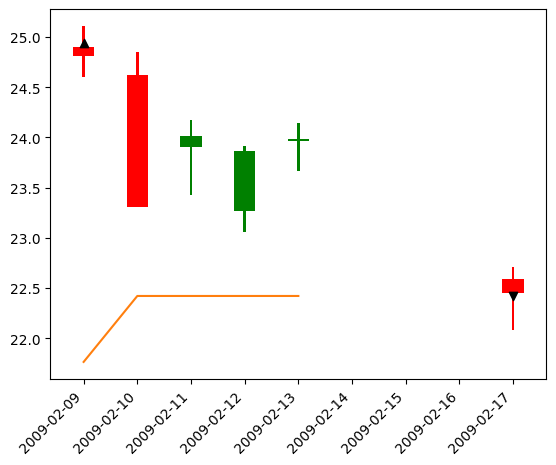

trade 44
entry: [23.979999542236328]
cost_basis: 23.979999542236328
exit: 26.739999771118164
returns: 0.11509592500285944
31


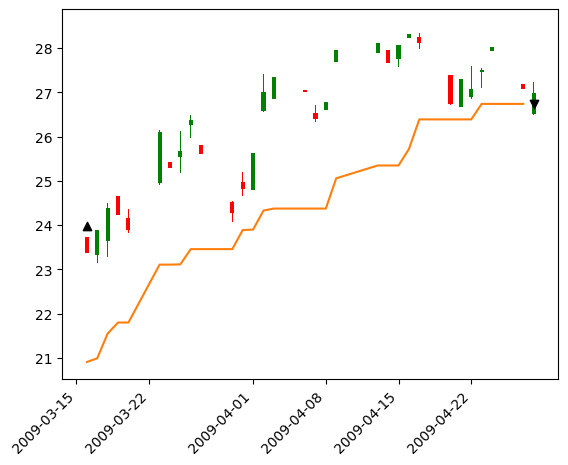

trade 45
entry: [28.309999465942383]
cost_basis: 28.309999465942383
exit: 31.627499103546143
returns: 0.11718472978407479
26


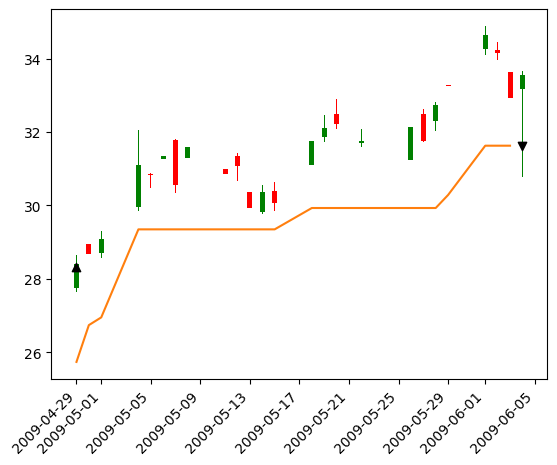

trade 46
entry: [32.81999969482422]
cost_basis: 32.81999969482422
exit: 35.439998626708984
returns: 0.07982934053158888
24


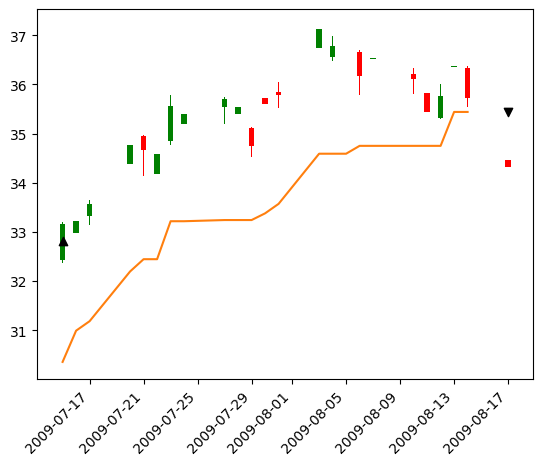

trade 47
entry: [36.470001220703125]
cost_basis: 36.470001220703125
exit: 39.20549983978272
returns: 0.0750068145741305
7


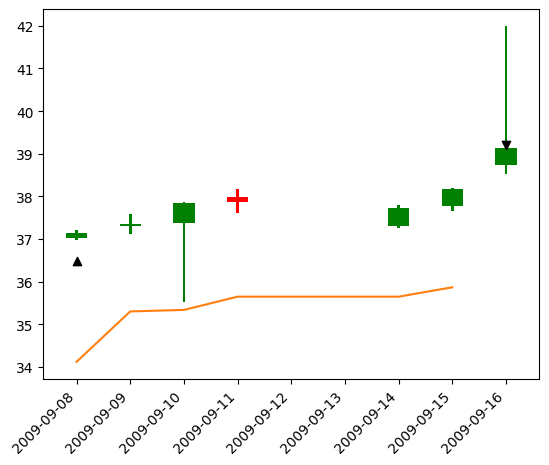

trade 48
entry: [39.130001068115234]
cost_basis: 39.130001068115234
exit: 37.720001220703125
returns: -0.036033728825043056
6


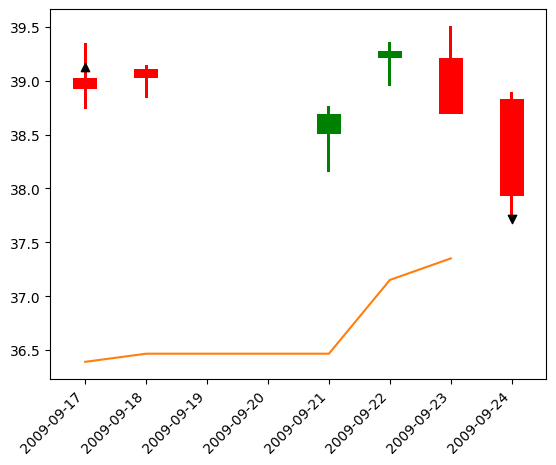

trade 49
entry: [39.27999877929688]
cost_basis: 39.27999877929688
exit: 37.93000030517578
returns: -0.03436859765974937
2


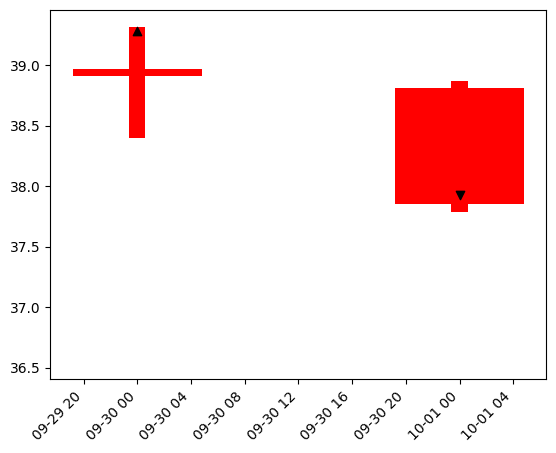

trade 50
entry: [39.27999877929688]
cost_basis: 39.27999877929688
exit: 40.18000030517578
returns: 0.02291246318350851
15


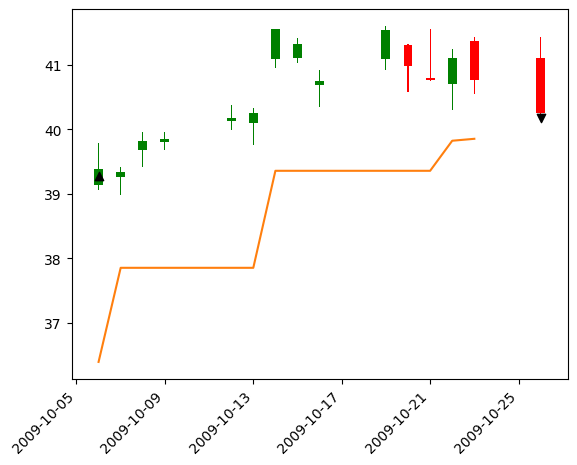

trade 51
entry: [41.54999923706055]
cost_basis: 41.54999923706055
exit: 40.34999847412109
returns: -0.028880885318262987
12


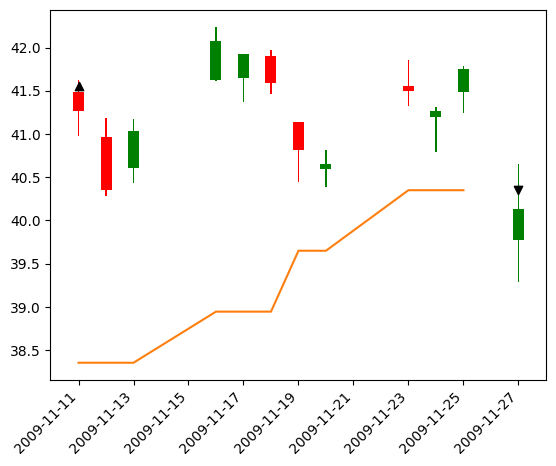

trade 52
entry: [42.06999969482422]
cost_basis: 42.06999969482422
exit: 40.709999084472656
returns: -0.03232708866691246
12


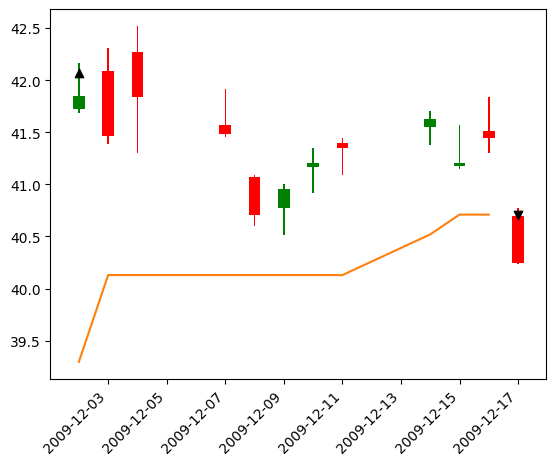

trade 53
entry: [41.84000015258789]
cost_basis: 41.84000015258789
exit: 41.950502777099615
returns: 0.0026410761020250525
10


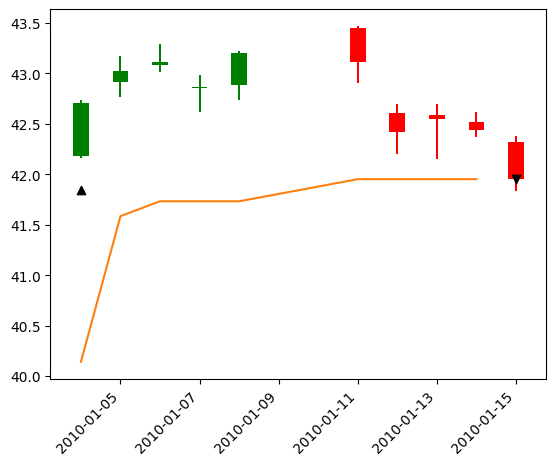

trade 54
entry: [39.720001220703125]
cost_basis: 39.720001220703125
exit: 40.97999954223633
returns: 0.031722011148289146
16


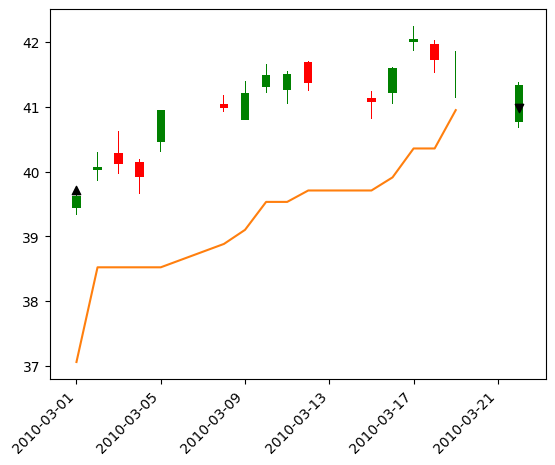

trade 55
entry: [42.04999923706055]
cost_basis: 42.04999923706055
exit: 44.45799922943115
returns: 0.057265161380748074
8


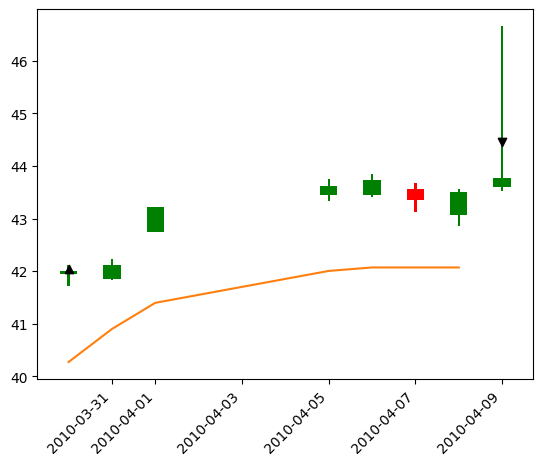

trade 56
entry: [43.77999877929688]
cost_basis: 43.77999877929688
exit: 43.220001220703125
returns: -0.012791173462950719
3


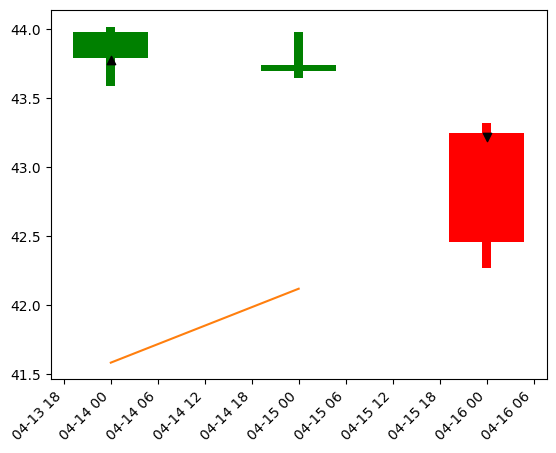

trade 57
entry: [39.4900016784668]
cost_basis: 39.4900016784668
exit: 38.970001220703125
returns: -0.013167901637421783
12


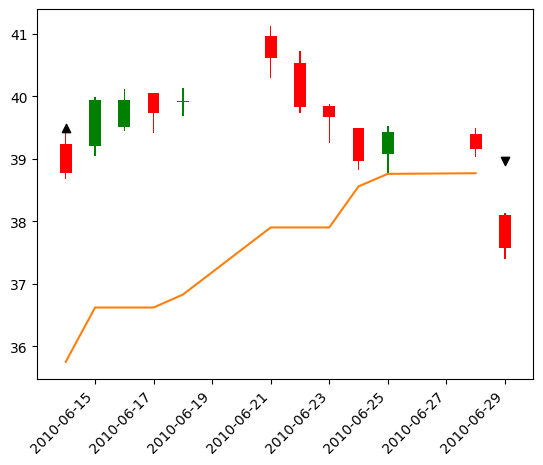

trade 58
entry: [40.11000061035156]
cost_basis: 40.11000061035156
exit: 41.130001068115234
returns: 0.025430078340622882
16


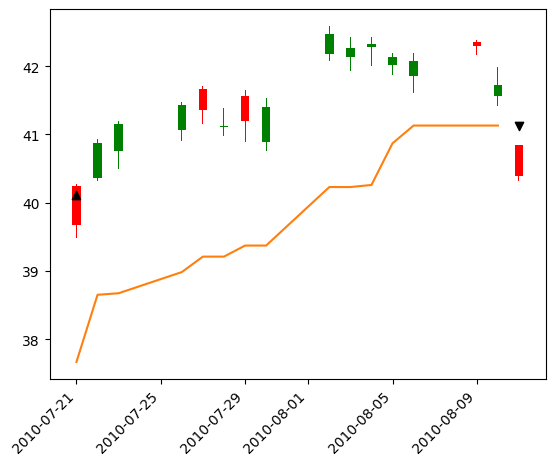

trade 59
entry: [42.02999877929688]
cost_basis: 42.02999877929688
exit: 45.68000030517578
returns: 0.08684277020909206
30


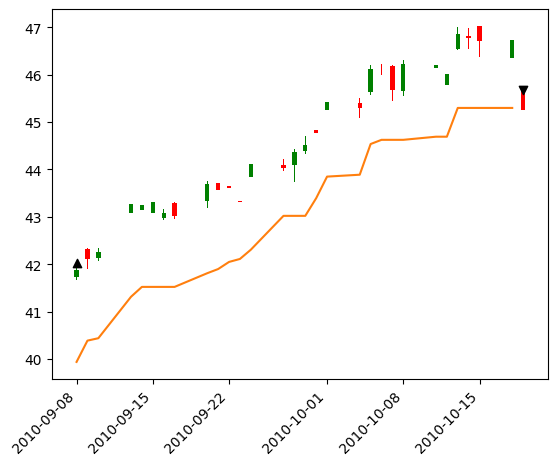

trade 60
entry: [46.86000061035156]
cost_basis: 46.86000061035156
exit: 46.43699932098388
returns: -0.00902691600209327
15


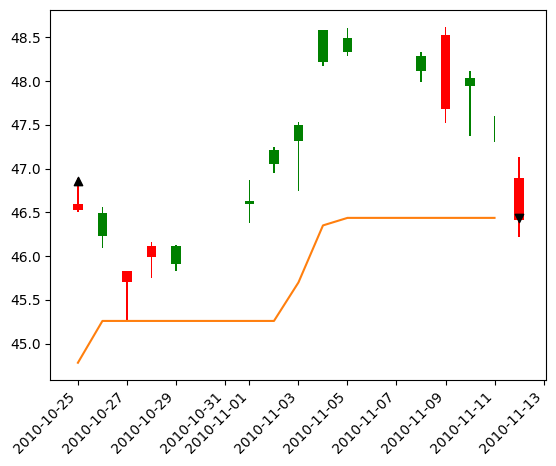

trade 61
entry: [47.13999938964844]
cost_basis: 47.13999938964844
exit: 47.025001525878906
returns: -0.0024394965052711446
7


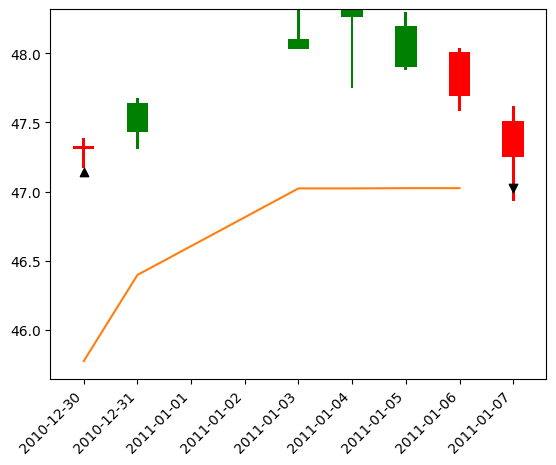

trade 62
entry: [46.58000183105469]
cost_basis: 46.58000183105469
exit: 45.31999969482422
returns: -0.027050280951050346
7


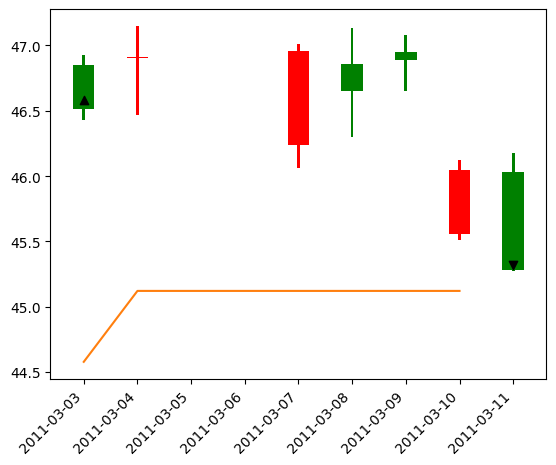

trade 63
entry: [46.95000076293945]
cost_basis: 46.95000076293945
exit: 48.52000045776367
returns: 0.03343982256254864
18


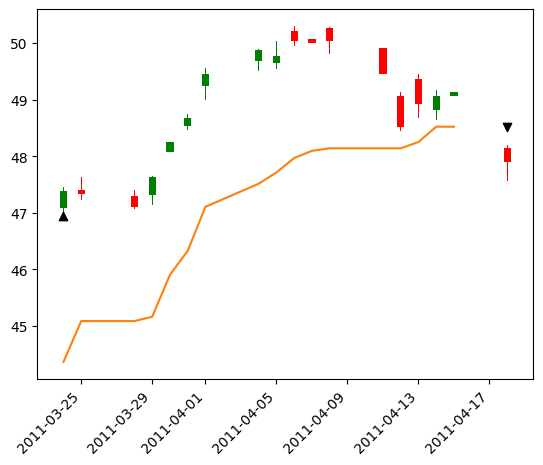

trade 64
entry: [50.040000915527344]
cost_basis: 50.040000915527344
exit: 48.59000015258789
returns: -0.02897683326159812
9


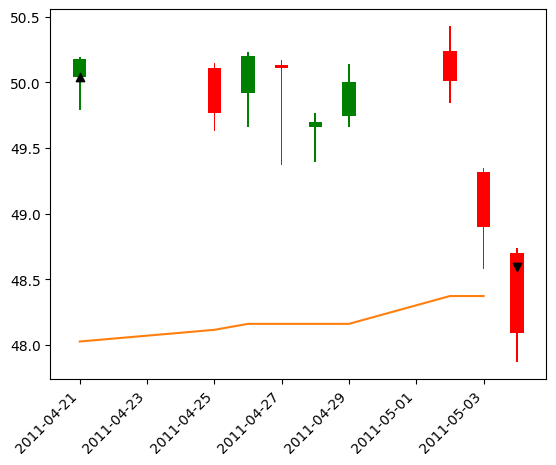

trade 65
entry: [47.869998931884766]
cost_basis: 47.869998931884766
exit: 46.38600120544434
returns: -0.031000579894560686
7


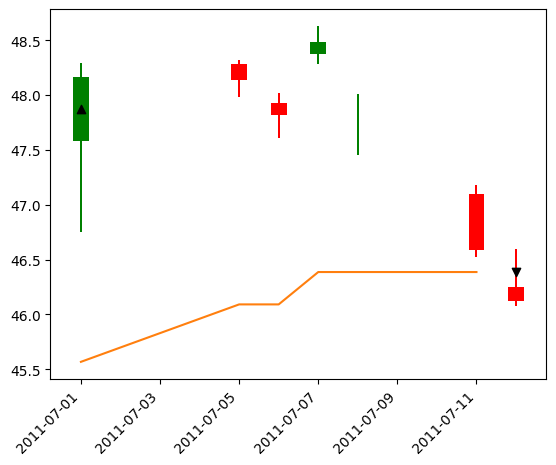

trade 66
entry: [42.86000061035156]
cost_basis: 42.86000061035156
exit: 40.0099983215332
returns: -0.06649561941746743
7


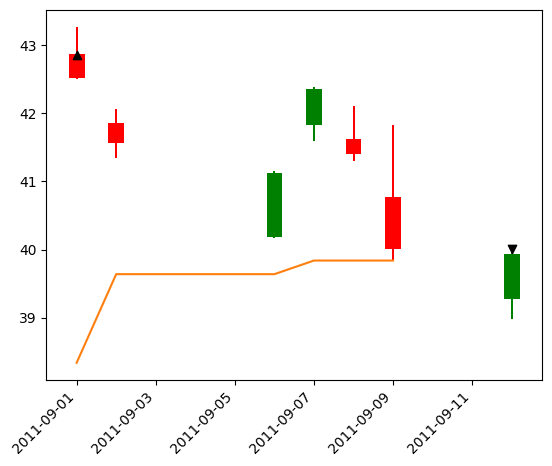

trade 67
entry: [39.59000015258789]
cost_basis: 39.59000015258789
exit: 39.168500900268555
returns: -0.010646609009719433
7


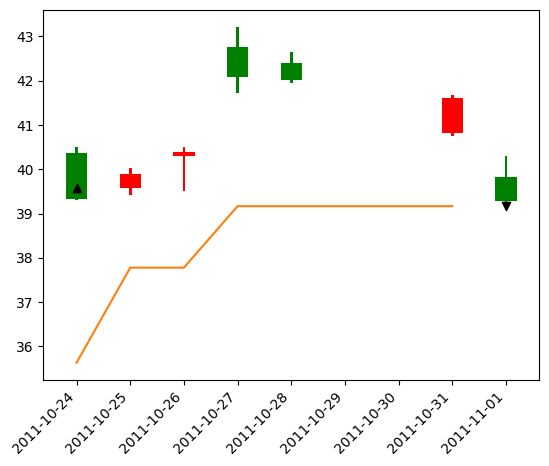

trade 68
entry: [39.369998931884766]
cost_basis: 39.369998931884766
exit: 43.75
returns: 0.11125225265291999
38


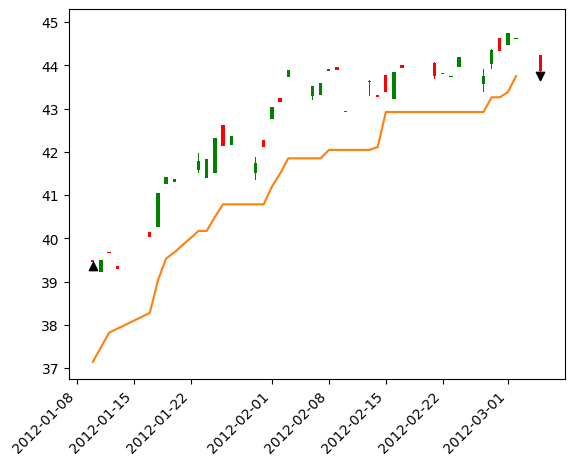

trade 69
entry: [38.2599983215332]
cost_basis: 38.2599983215332
exit: 37.638501930236814
returns: -0.01624402557661911
6


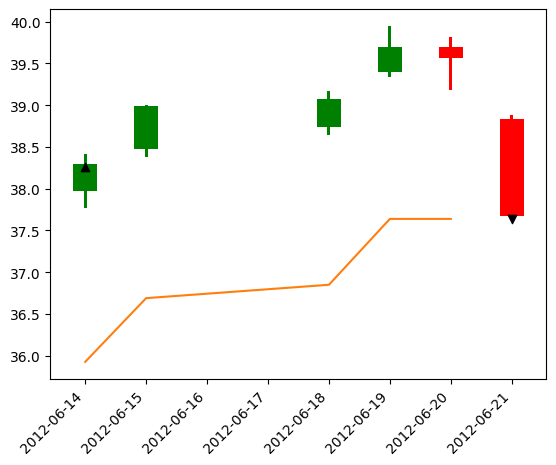

trade 70
entry: [39.70000076293945]
cost_basis: 39.70000076293945
exit: 37.470001220703125
returns: -0.056171272024711554
7


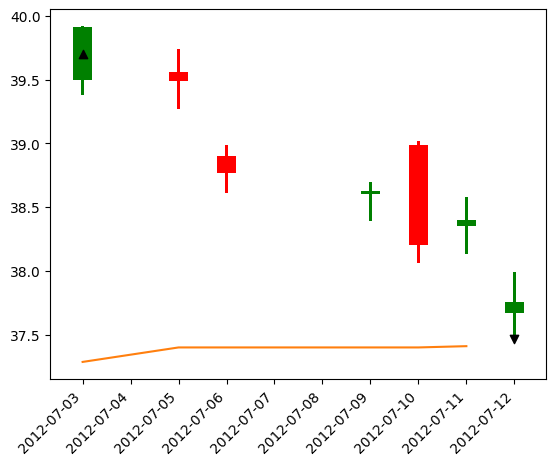

trade 71
entry: [39.90999984741211]
cost_basis: 39.90999984741211
exit: 40.18000030517578
returns: 0.006765233244699688
14


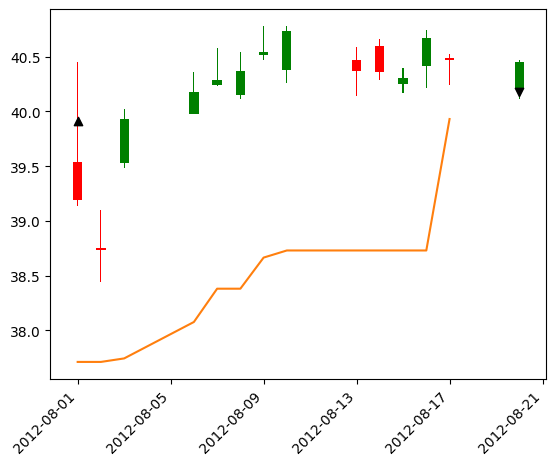

trade 72
entry: [40.72999954223633]
cost_basis: 40.72999954223633
exit: 40.29999923706055
returns: -0.0105573363616142
2


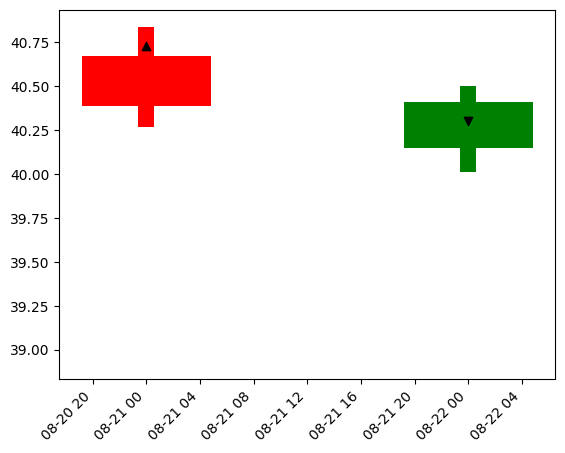

trade 73
entry: [40.66999816894531]
cost_basis: 40.66999816894531
exit: 41.101501274108884
returns: 0.010609862911010834
12


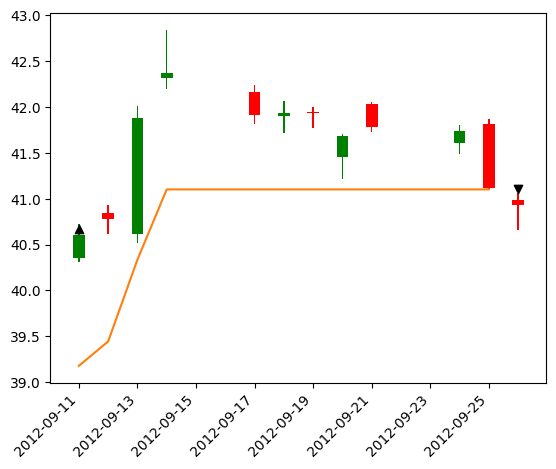

trade 74
entry: [41.95000076293945]
cost_basis: 41.95000076293945
exit: 41.02000045776367
returns: -0.0221692559776396
6


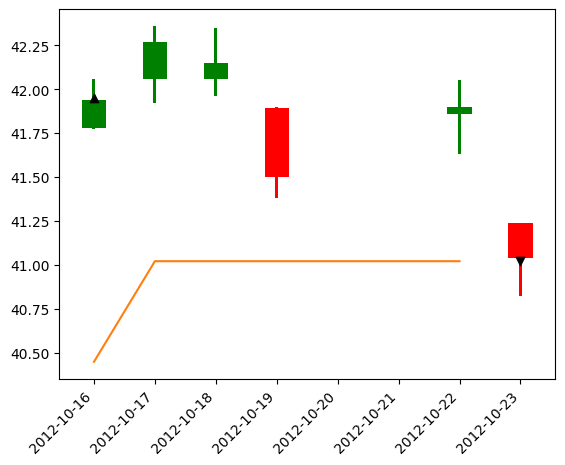

trade 75
entry: [42.130001068115234]
cost_basis: 42.130001068115234
exit: 44.00850162506104
returns: 0.04458819153383516
26


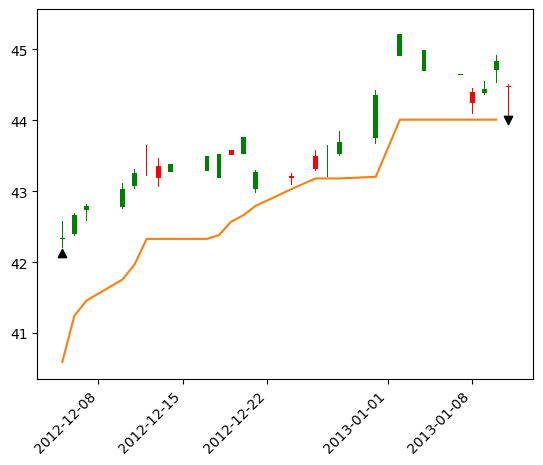

trade 76
entry: [44.16999816894531]
cost_basis: 44.16999816894531
exit: 42.900001525878906
returns: -0.02875247216920433
6


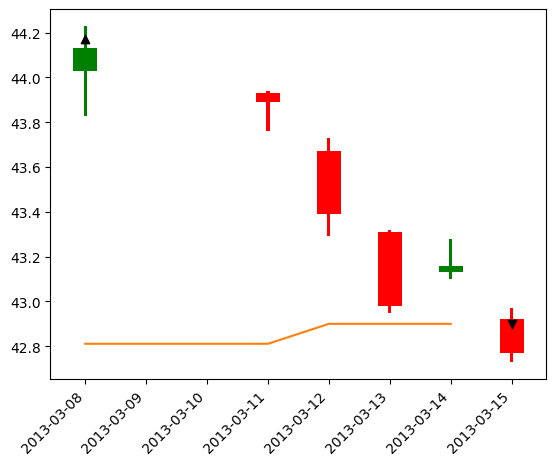

trade 77
entry: [42.77000045776367]
cost_basis: 42.77000045776367
exit: 43.16999816894531
returns: 0.009352296163210176
19


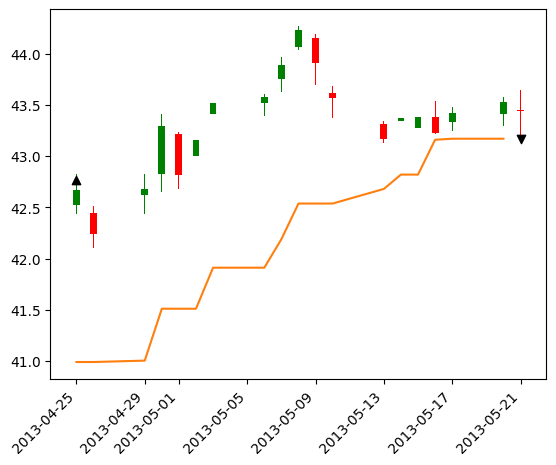

trade 78
entry: [39.84000015258789]
cost_basis: 39.84000015258789
exit: 39.27999877929688
returns: -0.014056259315918513
10


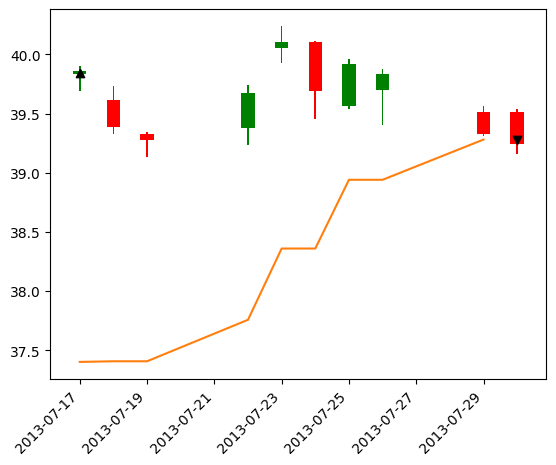

trade 79
entry: [40.09999847412109]
cost_basis: 40.09999847412109
exit: 38.58799819946289
returns: -0.037705743944952574
4


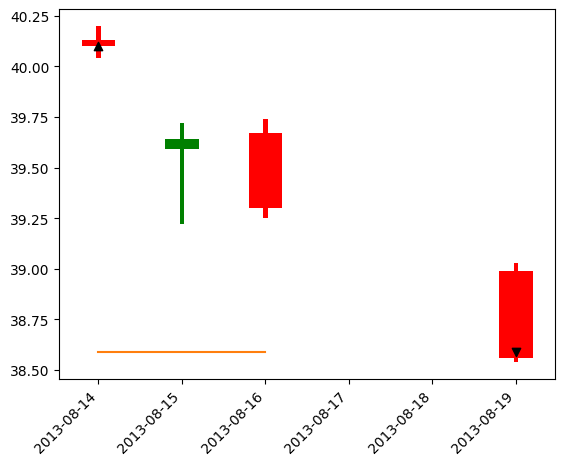

trade 80
entry: [40.09999847412109]
cost_basis: 40.09999847412109
exit: 41.20949859619141
returns: 0.02766833327403613
16


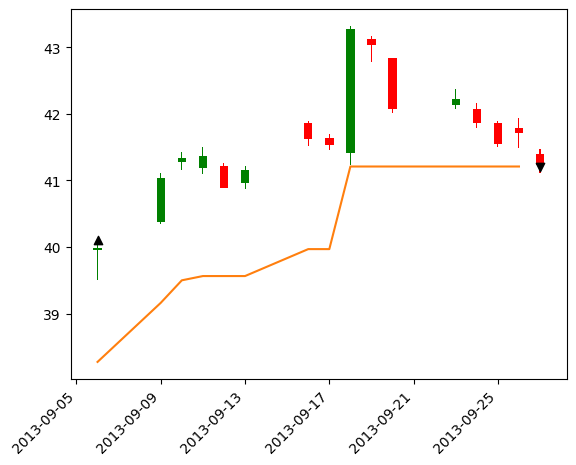

trade 81
entry: [43.08000183105469]
cost_basis: 43.08000183105469
exit: 42.63999938964844
returns: -0.01021361241189803
6


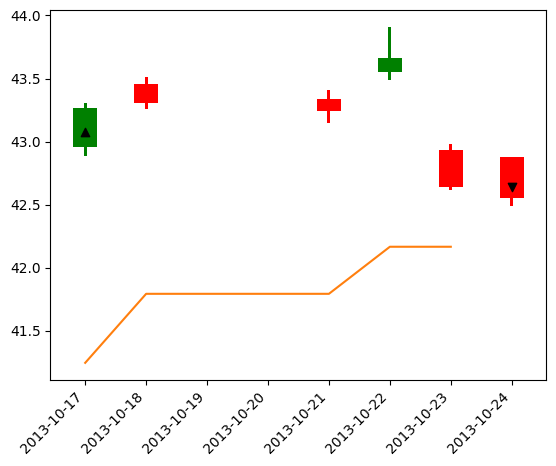

trade 82
entry: [39.65999984741211]
cost_basis: 39.65999984741211
exit: 38.97999954223633
returns: -0.01714574654039371
3


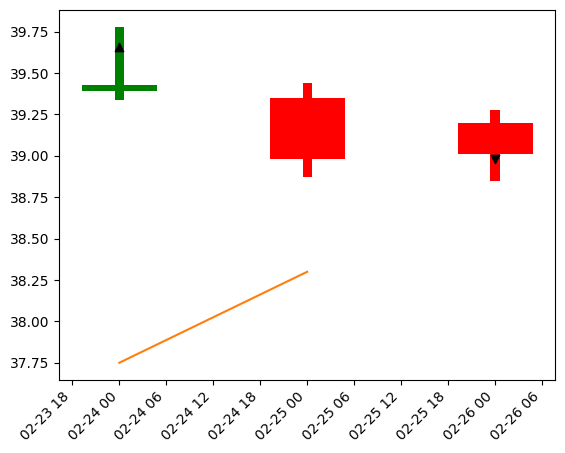

trade 83
entry: [39.65999984741211]
cost_basis: 39.65999984741211
exit: 38.97999954223633
returns: -0.01714574654039371
3


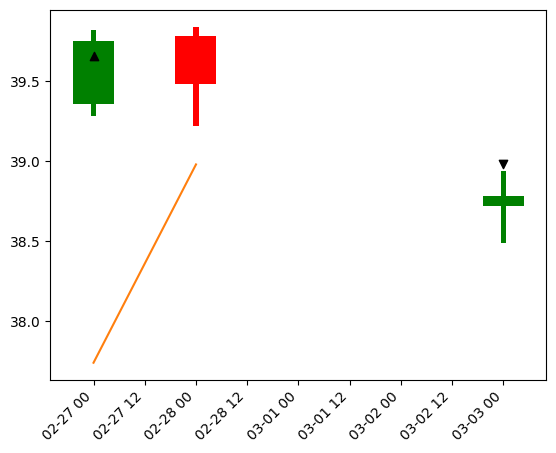

trade 84
entry: [39.75]
cost_basis: 39.75
exit: 38.77999877929688
returns: -0.02440254643278284
4


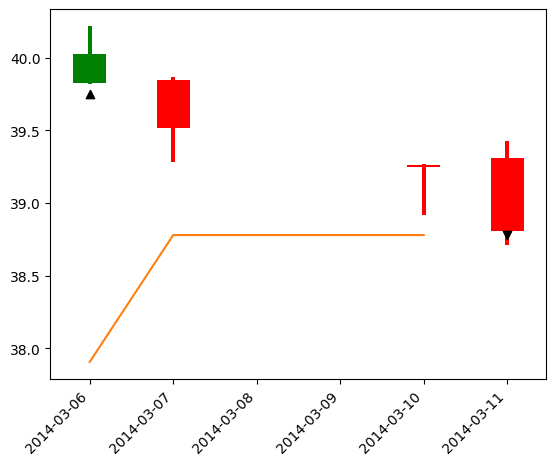

trade 85
entry: [40.02999877929688]
cost_basis: 40.02999877929688
exit: 41.29999923706055
returns: 0.0317262177489872
15


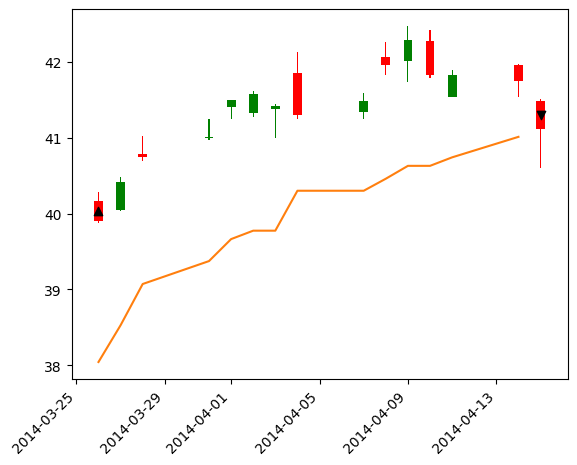

trade 86
entry: [42.0099983215332]
cost_basis: 42.0099983215332
exit: 43.40999984741211
returns: 0.03332543636787776
29


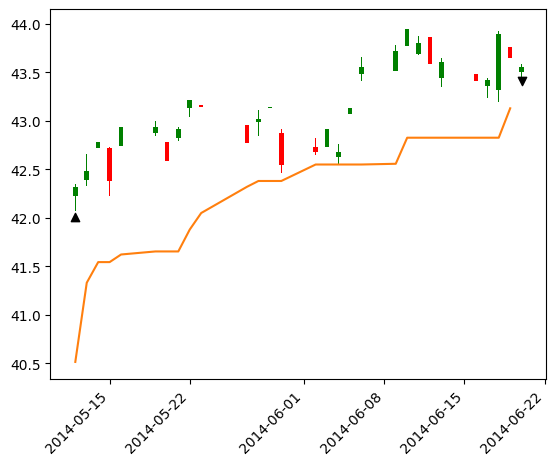

trade 87
entry: [43.95000076293945]
cost_basis: 43.95000076293945
exit: 43.88999938964844
returns: -0.0013652189362784127
10


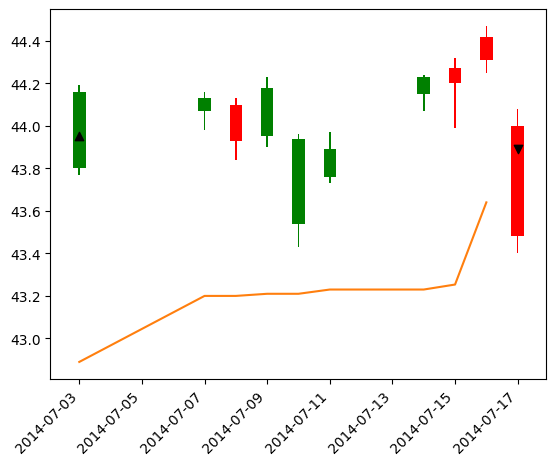

trade 88
entry: [44.310001373291016]
cost_basis: 44.310001373291016
exit: 43.93150024414063
returns: -0.008542115039936278
9


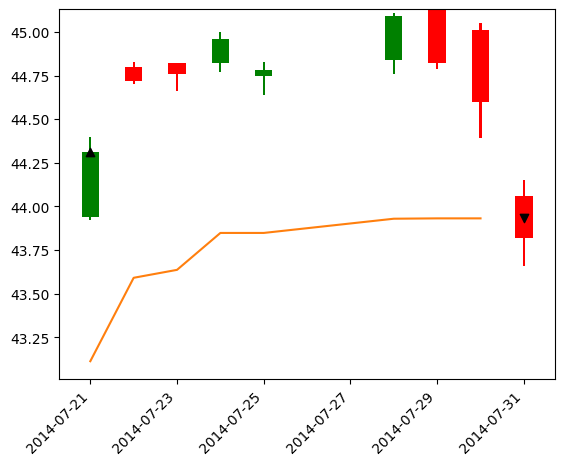

trade 89
entry: [45.09000015258789]
cost_basis: 45.09000015258789
exit: 44.9900016784668
returns: -0.0022177528006806727
15


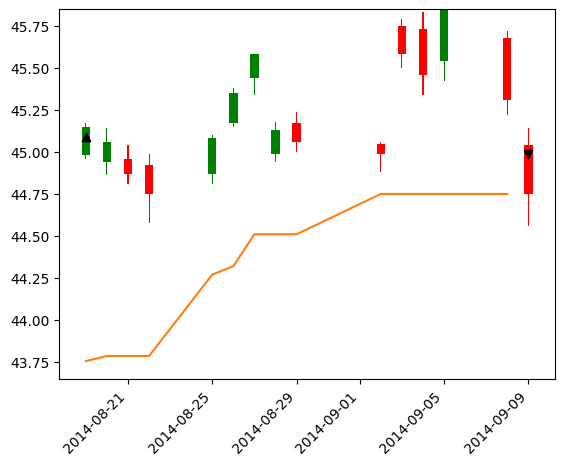

trade 90
entry: [42.06999969482422]
cost_basis: 42.06999969482422
exit: 40.959999084472656
returns: -0.026384611799465343
13


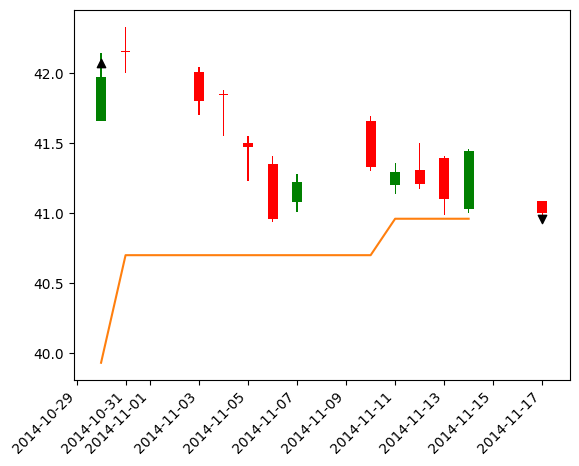

trade 91
entry: [42.150001525878906]
cost_basis: 42.150001525878906
exit: 41.0015007019043
returns: -0.027247942642883678
6


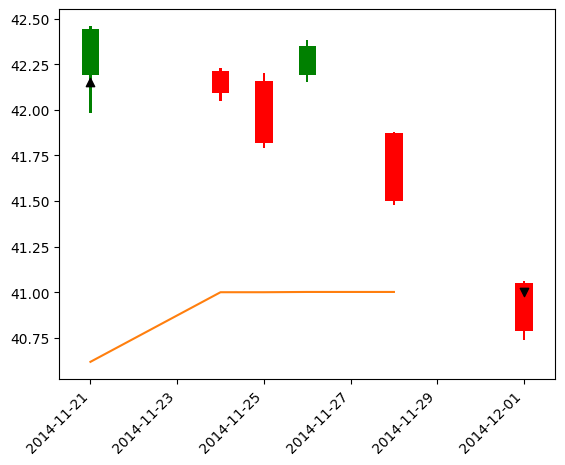

trade 92
entry: [39.41999816894531]
cost_basis: 39.41999816894531
exit: 39.47799873352051
returns: 0.0014713487384402668
15


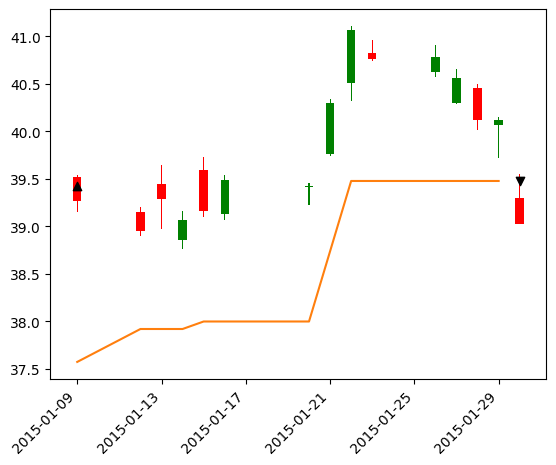

trade 93
entry: [40.77999877929688]
cost_basis: 40.77999877929688
exit: 40.2599983215332
returns: -0.012751360307241399
7


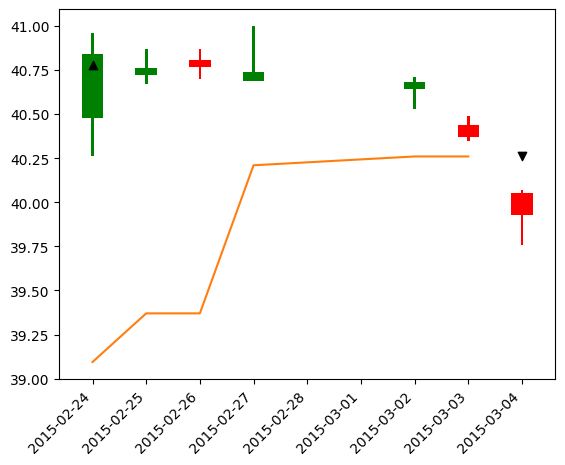

trade 94
entry: [40.36000061035156]
cost_basis: 40.36000061035156
exit: 42.880001068115234
returns: 0.06243806788043854
25


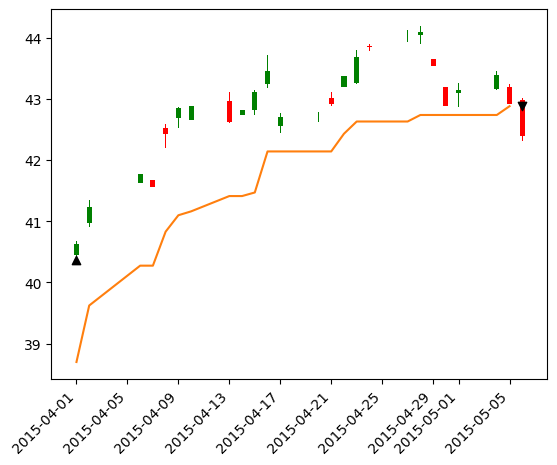

trade 95
entry: [34.54999923706055]
cost_basis: 34.54999923706055
exit: 32.9900016784668
returns: -0.04515188402436769
4


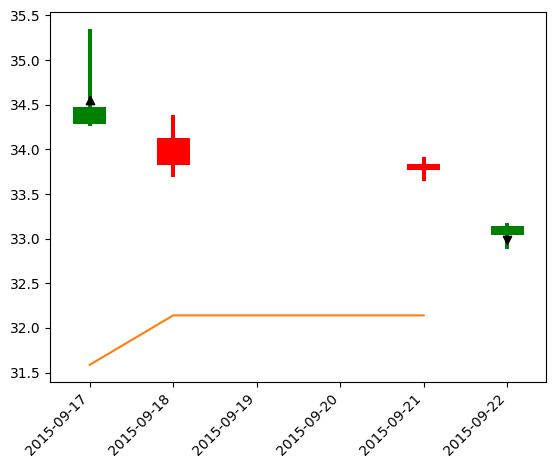

trade 96
entry: [34.54999923706055]
cost_basis: 34.54999923706055
exit: 35.349998474121094
returns: 0.02315482647543495
18


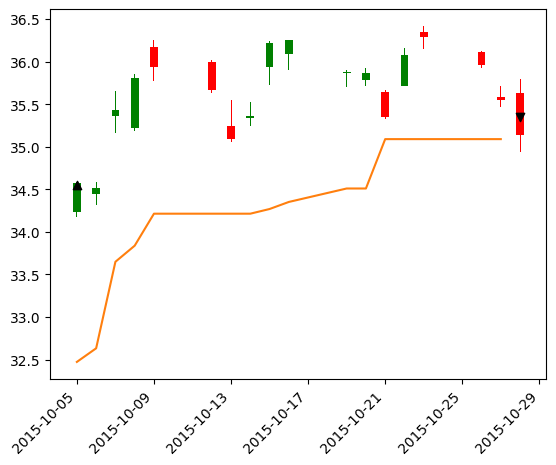

trade 97
entry: [30.56999969482422]
cost_basis: 30.56999969482422
exit: 33.36000061035156
returns: 0.09126597786651978
34


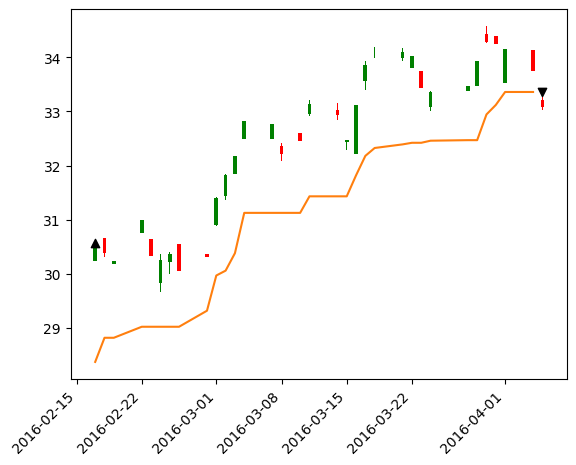

trade 98
entry: [34.279998779296875]
cost_basis: 34.279998779296875
exit: 34.31999969482422
returns: 0.0011668878924086187
14


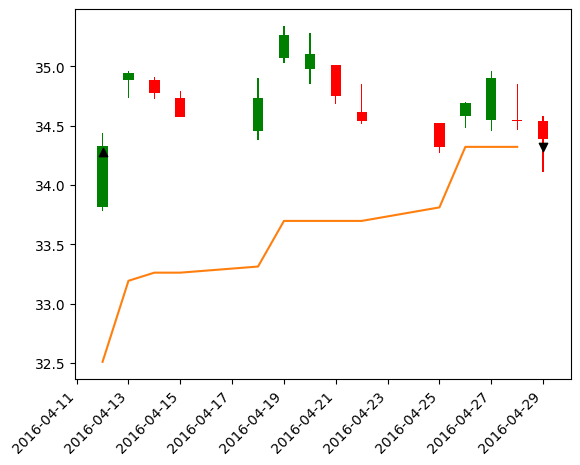

trade 99
entry: [33.119998931884766]
cost_basis: 33.119998931884766
exit: 33.64950065612793
returns: 0.01598737141665206
7


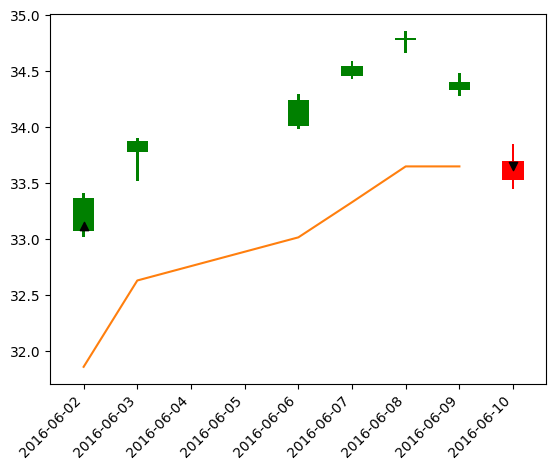

trade 100
entry: [34.7599983215332]
cost_basis: 34.7599983215332
exit: 35.61000061035156
returns: 0.024453461733679027
18


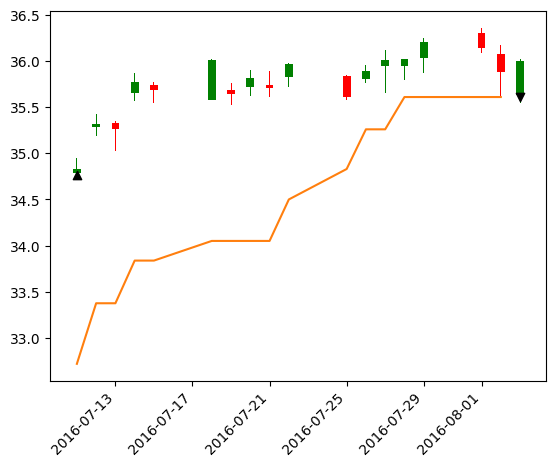

trade 101
entry: [36.209999084472656]
cost_basis: 36.209999084472656
exit: 37.09999847412109
returns: 0.024578829388318717
14


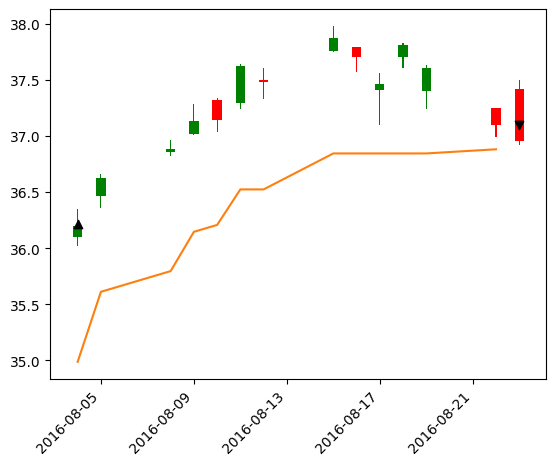

trade 102
entry: [37.869998931884766]
cost_basis: 37.869998931884766
exit: 36.83000144958496
returns: -0.02746230556199393
4


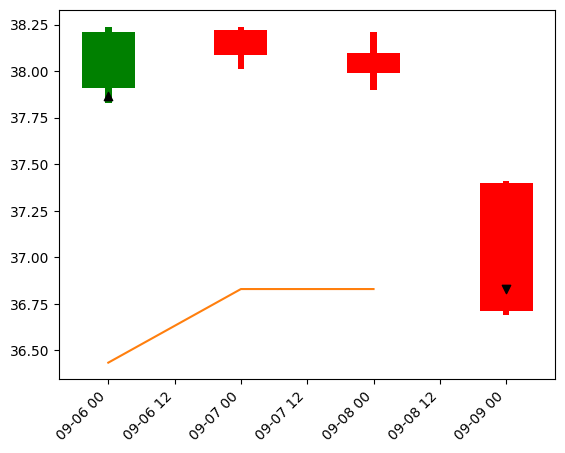

trade 103
entry: [38.209999084472656]
cost_basis: 38.209999084472656
exit: 37.290000915527344
returns: -0.02407741928785261
14


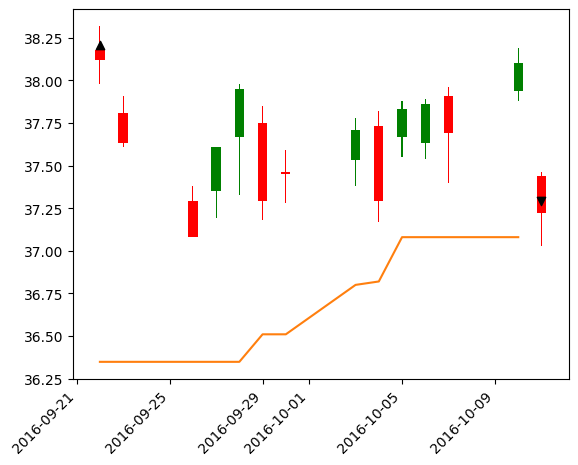

trade 104
entry: [36.25]
cost_basis: 36.25
exit: 35.25050048828125
returns: -0.02757240032327594
5


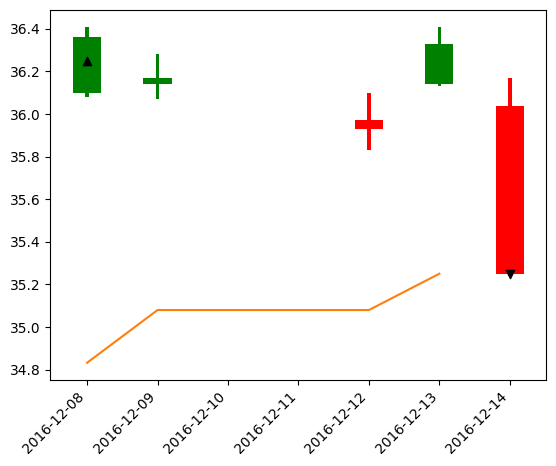

trade 105
entry: [36.33000183105469]
cost_basis: 36.33000183105469
exit: 38.35650081634522
returns: 0.05578031607910049
32


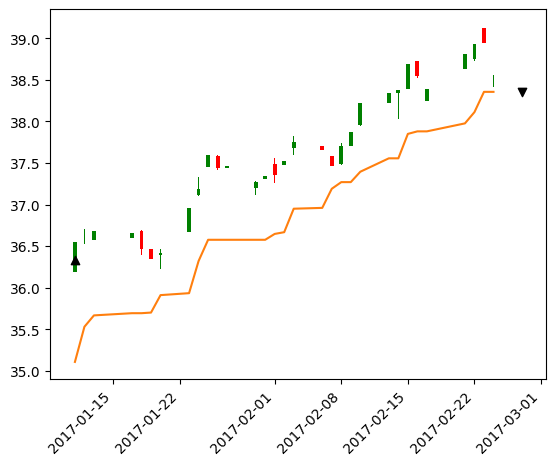

trade 106
entry: [38.93999862670898]
cost_basis: 38.93999862670898
exit: 39.4900016784668
returns: 0.014124372654203743
13


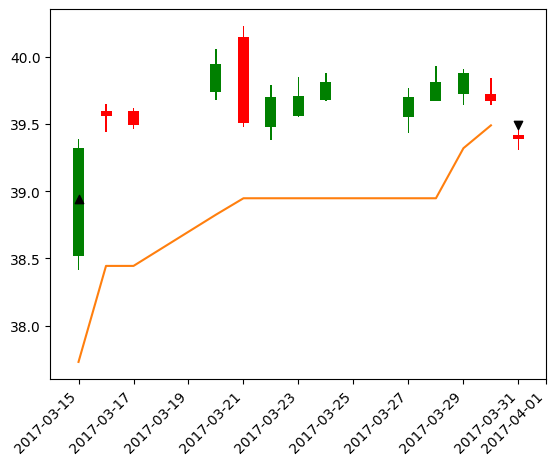

trade 107
entry: [39.880001068115234]
cost_basis: 39.880001068115234
exit: 40.63500156402588
returns: 0.018931807314174806
19


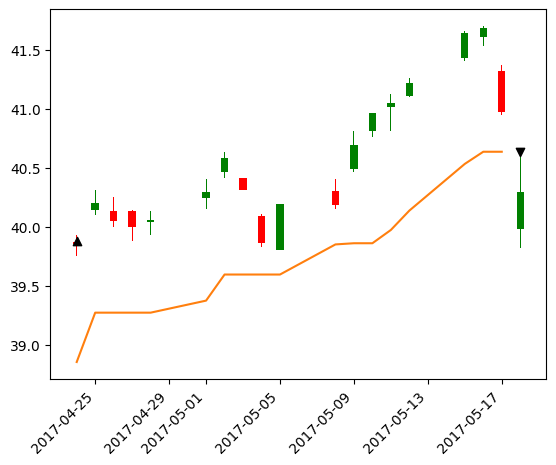

trade 108
entry: [41.68000030517578]
cost_basis: 41.68000030517578
exit: 41.20000076293945
returns: -0.011516303712136064
12


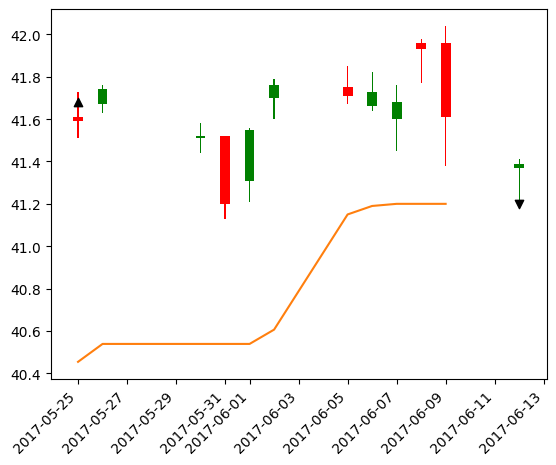

trade 109
entry: [41.93000030517578]
cost_basis: 41.93000030517578
exit: 40.97999954223633
returns: -0.02265682699797611
4


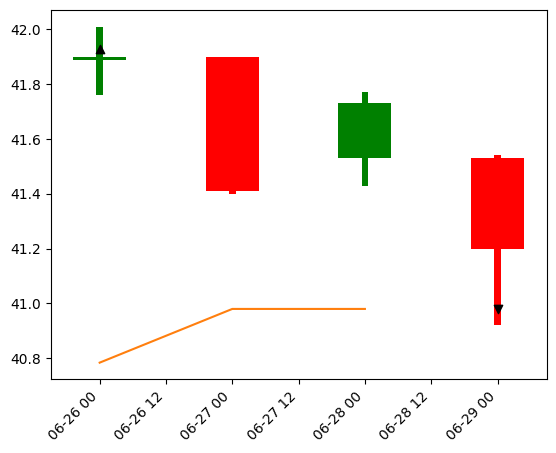

trade 110
entry: [41.900001525878906]
cost_basis: 41.900001525878906
exit: 43.630001068115234
returns: 0.041288770387462155
18


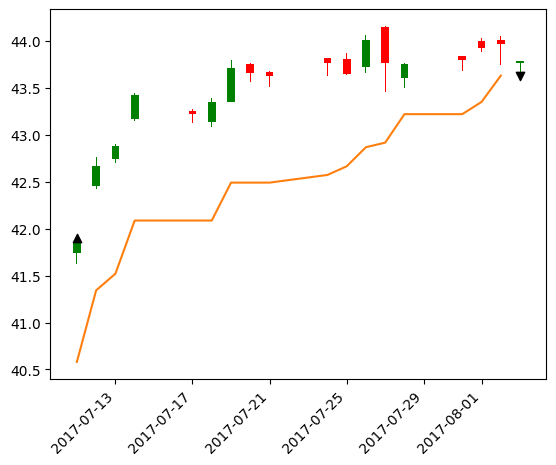

trade 111
entry: [44.0099983215332]
cost_basis: 44.0099983215332
exit: 43.75
returns: -0.00590771032604178
3


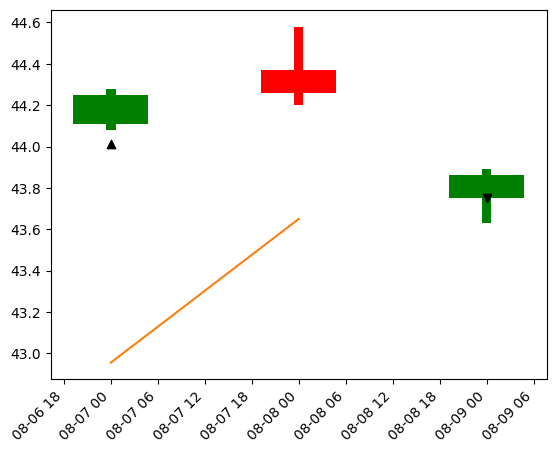

trade 112
entry: [44.2599983215332]
cost_basis: 44.2599983215332
exit: 45.20000076293945
returns: 0.02123819423980691
24


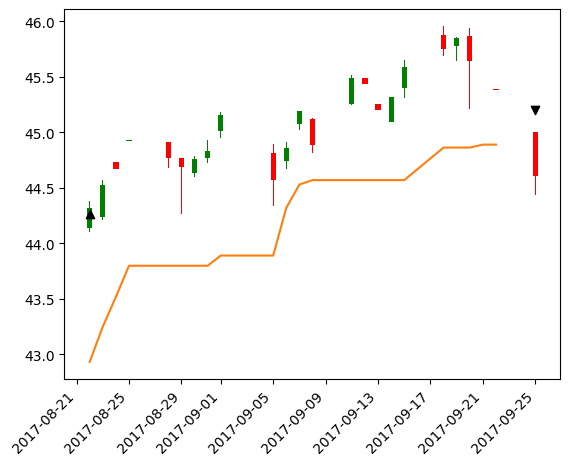

trade 113
entry: [45.84999847412109]
cost_basis: 45.84999847412109
exit: 45.88999938964844
returns: 0.0008724300296308275
14


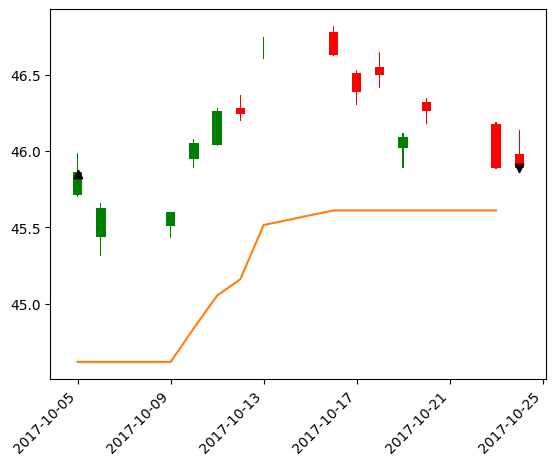

trade 114
entry: [46.65999984741211]
cost_basis: 46.65999984741211
exit: 46.18999862670898
returns: -0.010072893747109596
10


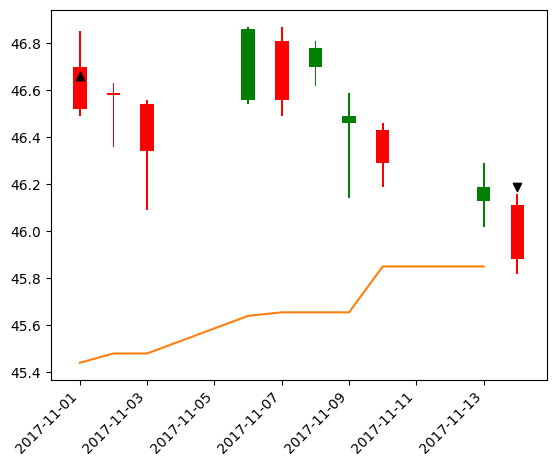

trade 115
entry: [46.86000061035156]
cost_basis: 46.86000061035156
exit: 46.52000122070313
returns: -0.007255642023472914
8


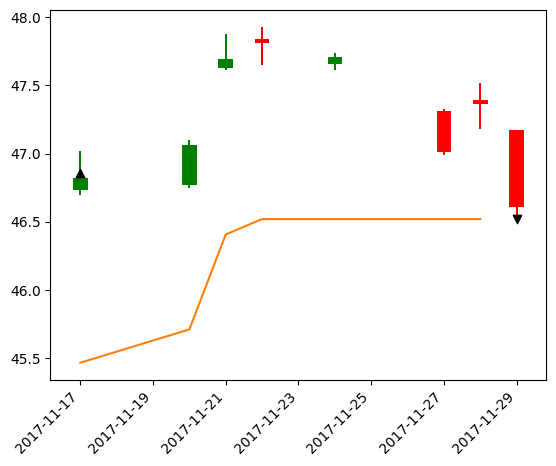

trade 116
entry: [46.68999862670898]
cost_basis: 46.68999862670898
exit: 50.622001075744635
returns: 0.08421509026959702
22


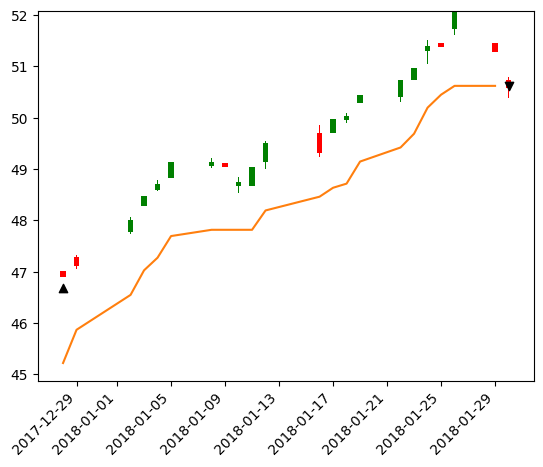

trade 117
entry: [44.18999862670898]
cost_basis: 44.18999862670898
exit: 43.869998931884766
returns: -0.007241450662340594
14


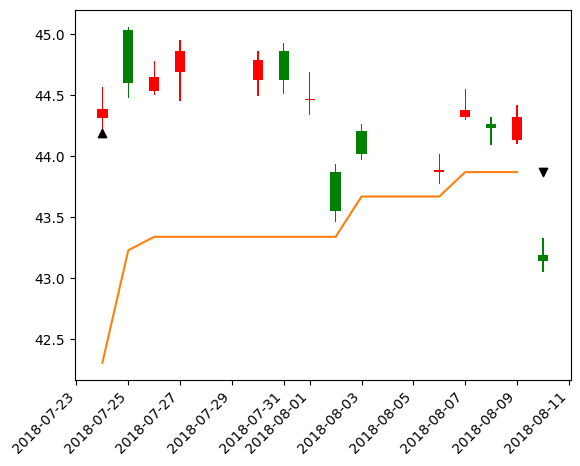

trade 118
entry: [40.900001525878906]
cost_basis: 40.900001525878906
exit: 39.89100246429444
returns: -0.024669902785848023
23


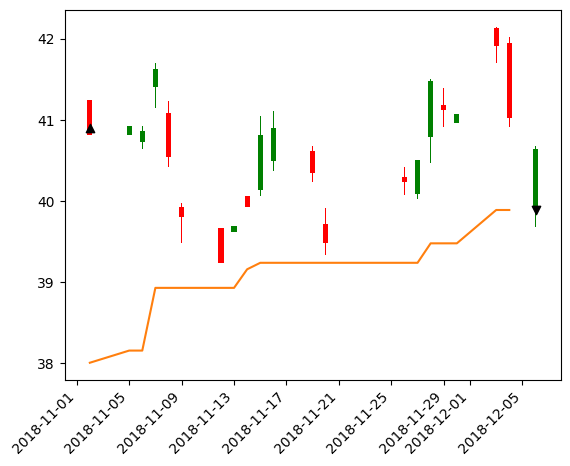

trade 119
entry: [40.40999984741211]
cost_basis: 40.40999984741211
exit: 42.02000045776367
returns: 0.039841638614969414
25


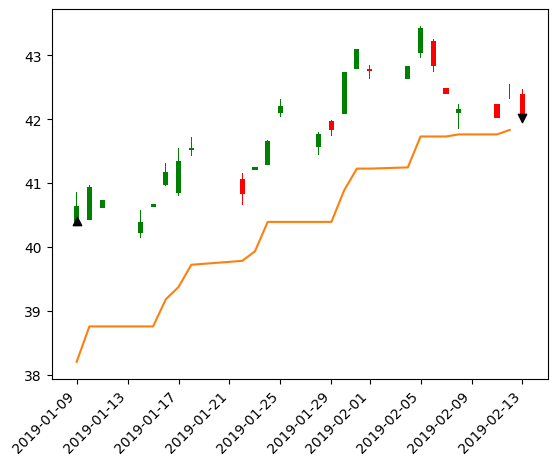

trade 120
entry: [43.41999816894531]
cost_basis: 43.41999816894531
exit: 42.43999862670898
returns: -0.02257023453624295
9


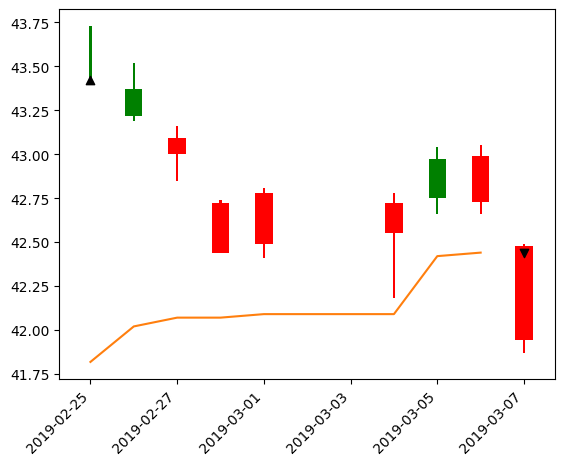

trade 121
entry: [43.52000045776367]
cost_basis: 43.52000045776367
exit: 42.45749740600586
returns: -0.024414132366312326
5


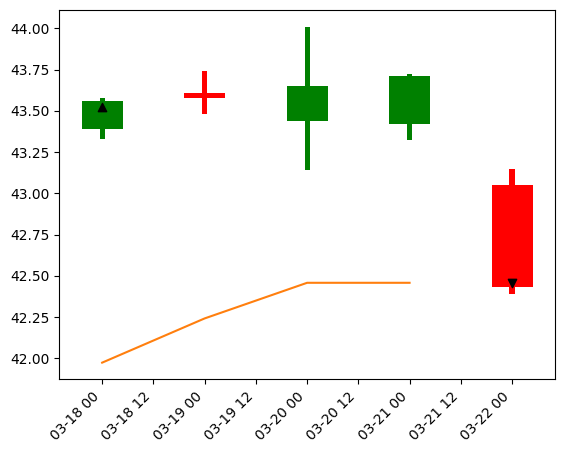

trade 122
entry: [43.709999084472656]
cost_basis: 43.709999084472656
exit: 44.040000915527344
returns: 0.007549801829483814
15


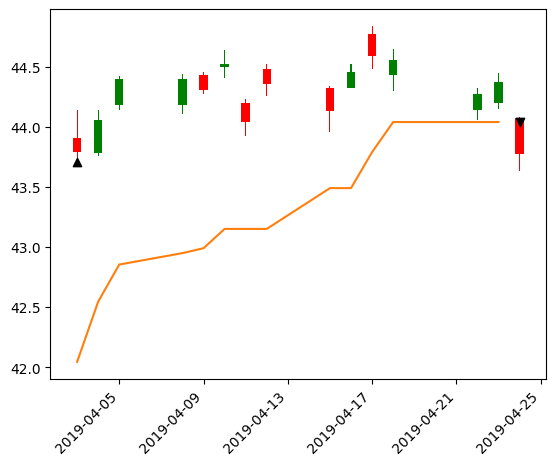

trade 123
entry: [41.61000061035156]
cost_basis: 41.61000061035156
exit: 40.84000015258789
returns: -0.018505177757005713
5


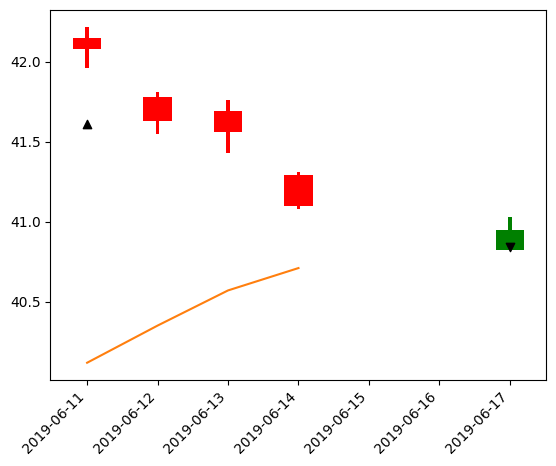

trade 124
entry: [42.08000183105469]
cost_basis: 42.08000183105469
exit: 42.81999969482422
returns: 0.01758549979965588
26


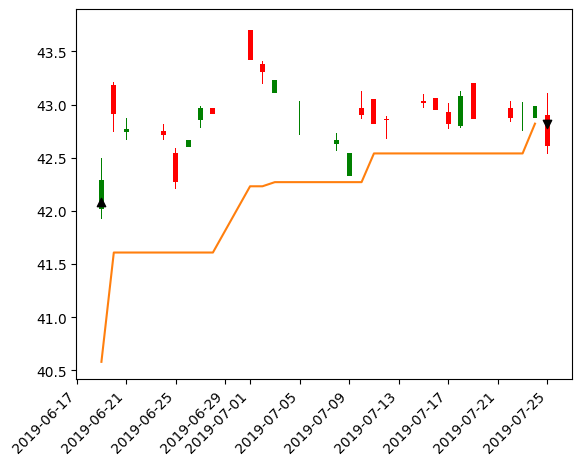

trade 125
entry: [40.27999877929688]
cost_basis: 40.27999877929688
exit: 41.40999984741211
returns: 0.02805365199504488
15


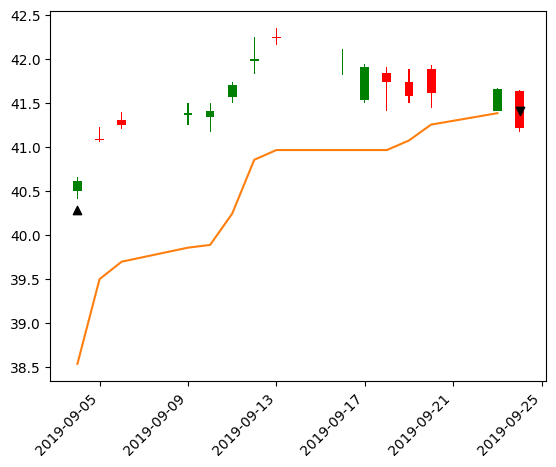

trade 126
entry: [41.90999984741211]
cost_basis: 41.90999984741211
exit: 43.0425006866455
returns: 0.027022210531058372
21


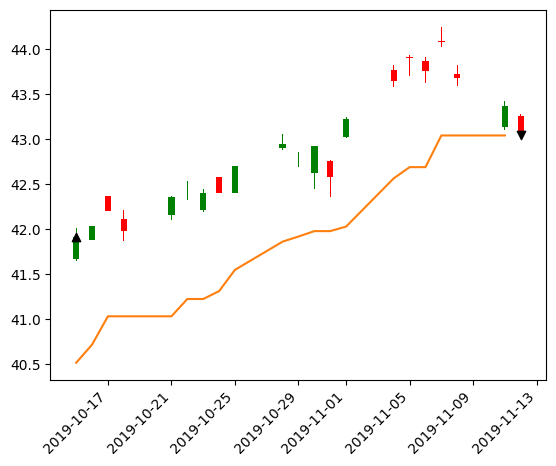

trade 127
entry: [43.29999923706055]
cost_basis: 43.29999923706055
exit: 44.61000061035157
returns: 0.030254073819239013
17


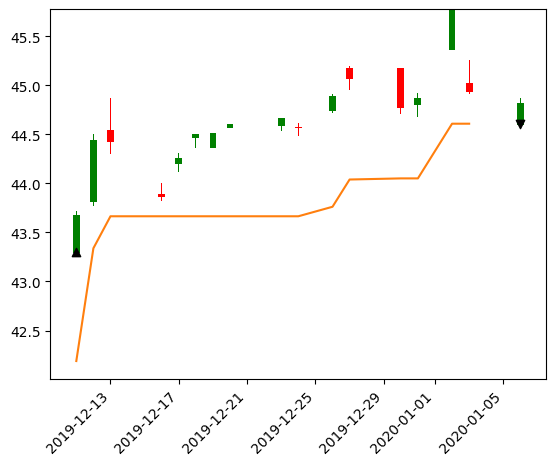

trade 128
entry: [45.77999877929688]
cost_basis: 45.77999877929688
exit: 45.04049930572509
returns: -0.016153331002407418
6


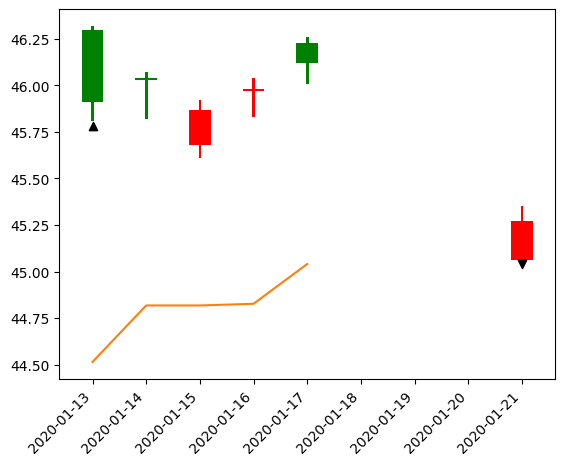

trade 129
entry: [35.47999954223633]
cost_basis: 35.47999954223633
exit: 34.939998626708984
returns: -0.015219868165006947
6


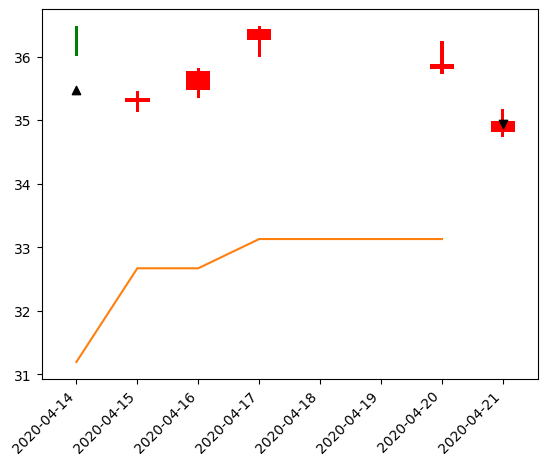

trade 130
entry: [36.2599983215332]
cost_basis: 36.2599983215332
exit: 38.794500732421874
returns: 0.06989802890816854
37


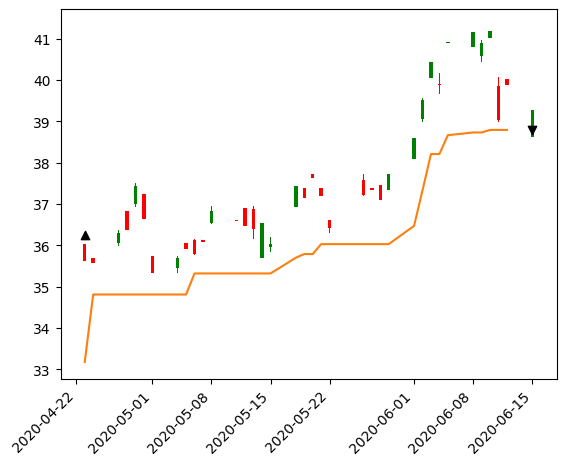

trade 131
entry: [41.18999862670898]
cost_basis: 41.18999862670898
exit: 43.86000061035156
returns: 0.0648216089502675
35


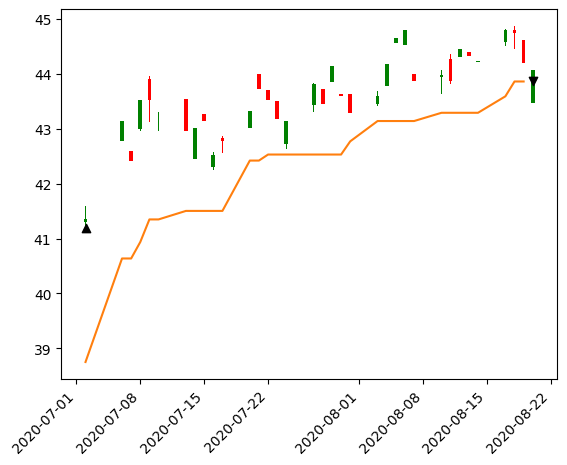

trade 132
entry: [44.79999923706055]
cost_basis: 44.79999923706055
exit: 44.060001373291016
returns: -0.016517809740437945
9


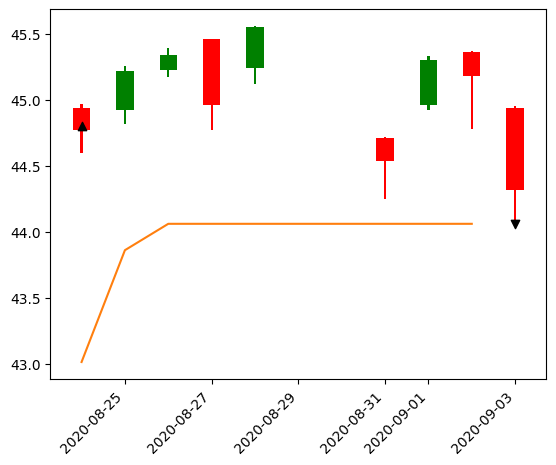

trade 133
entry: [45.11000061035156]
cost_basis: 45.11000061035156
exit: 45.400001525878906
returns: 0.006428749980127381
14


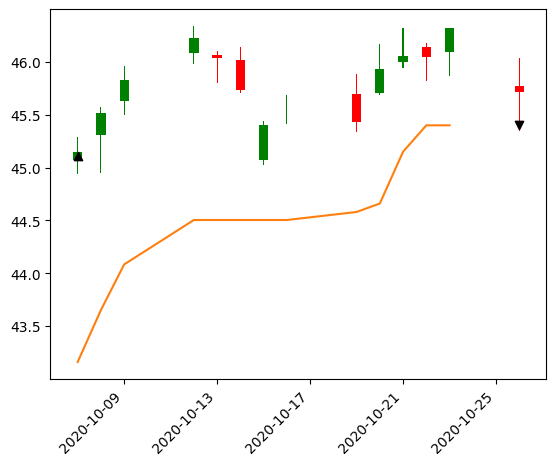

trade 134
entry: [46.31999969482422]
cost_basis: 46.31999969482422
exit: 49.93999862670898
returns: 0.07815196363848975
33


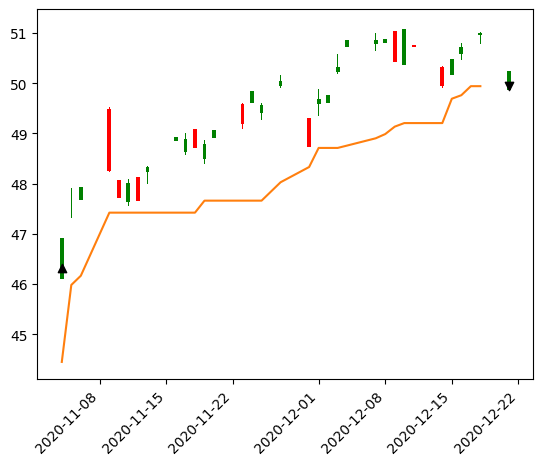

trade 135
entry: [51.08000183105469]
cost_basis: 51.08000183105469
exit: 54.34999847412109
returns: 0.06401715986388955
19


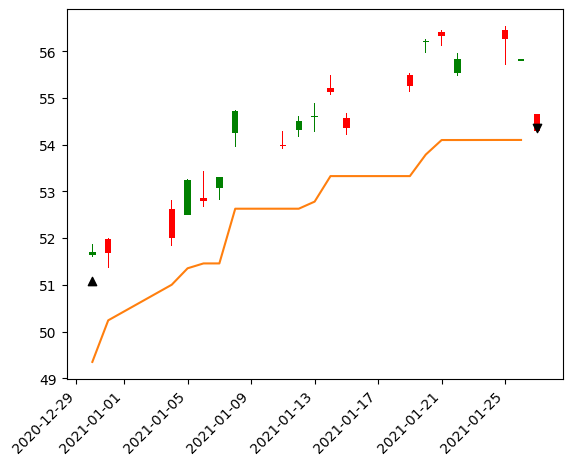

trade 136
entry: [56.31999969482422]
cost_basis: 56.31999969482422
exit: 56.2400016784668
returns: -0.0014204193322247772
10


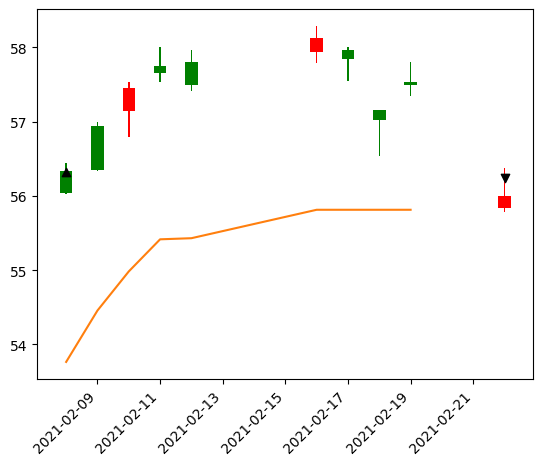

trade 137
entry: [54.369998931884766]
cost_basis: 54.369998931884766
exit: 53.709999084472656
returns: -0.012139044700717454
13


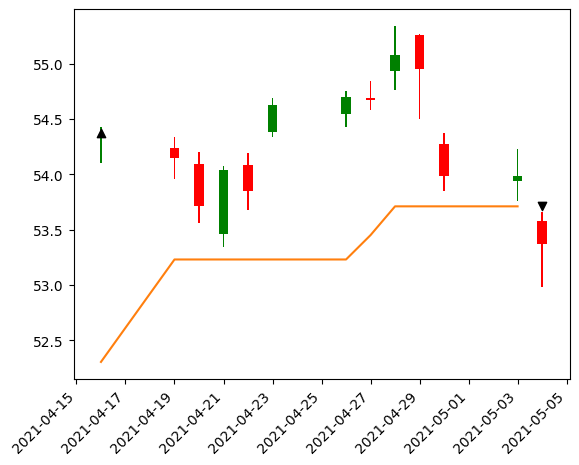

trade 138
entry: [54.68999862670898]
cost_basis: 54.68999862670898
exit: 55.27999877929688
returns: 0.01078808132022454
12


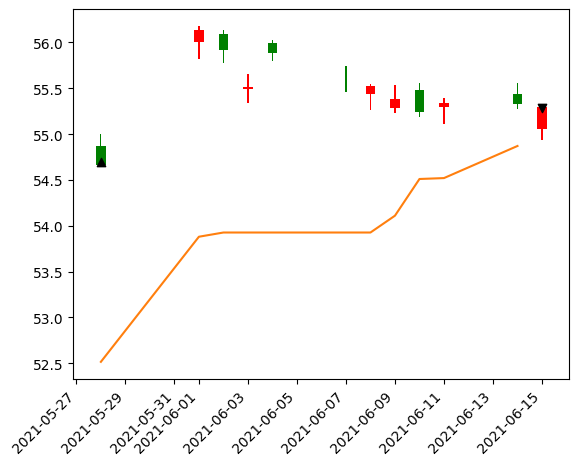

trade 139
entry: [52.459999084472656]
cost_basis: 52.459999084472656
exit: 52.18999862670898
returns: -0.0051467873136809665
11


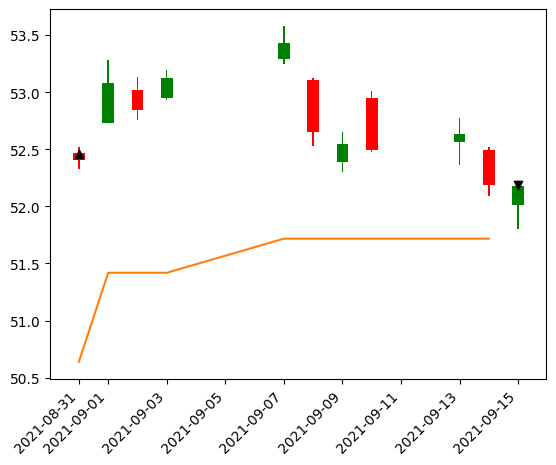

trade 140
entry: [51.38999938964844]
cost_basis: 51.38999938964844
exit: 51.31999969482422
returns: -0.0013621267883945313
10


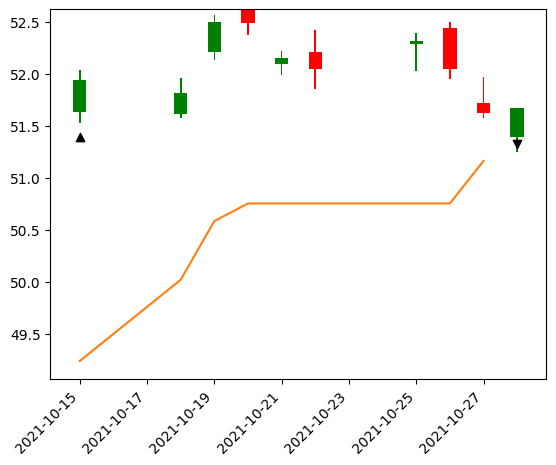

trade 141
entry: [49.20000076293945]
cost_basis: 49.20000076293945
exit: 49.06900005340576
returns: -0.0026626160061438914
8


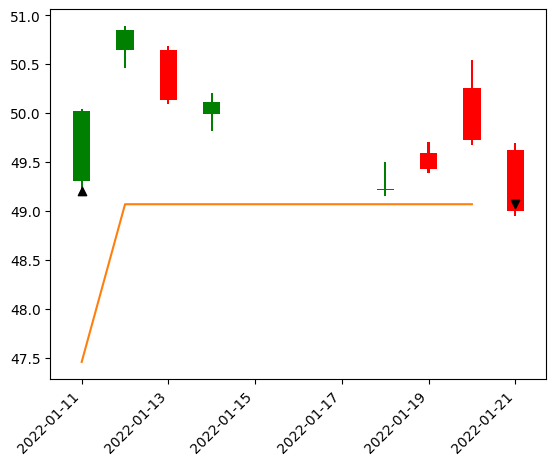

trade 142
entry: [49.79999923706055]
cost_basis: 49.79999923706055
exit: 48.380001068115234
returns: -0.028514019893569945
4


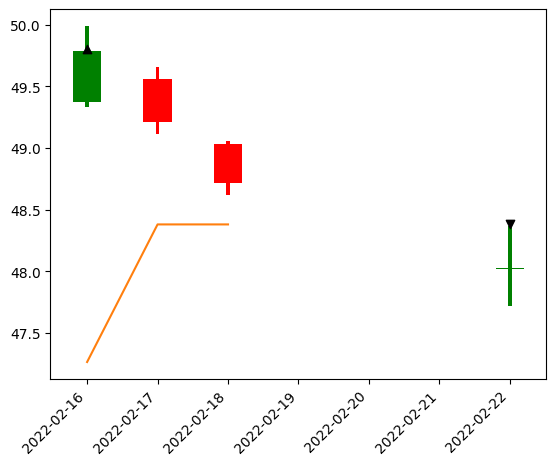

trade 143
entry: [46.18999862670898]
cost_basis: 46.18999862670898
exit: 45.04999923706055
returns: -0.02468065433085411
6


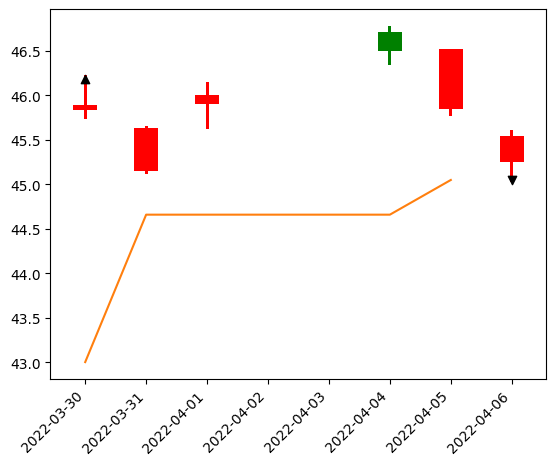

trade 144
entry: [43.09000015258789]
cost_basis: 43.09000015258789
exit: 41.56999969482422
returns: -0.035275016300327956
9


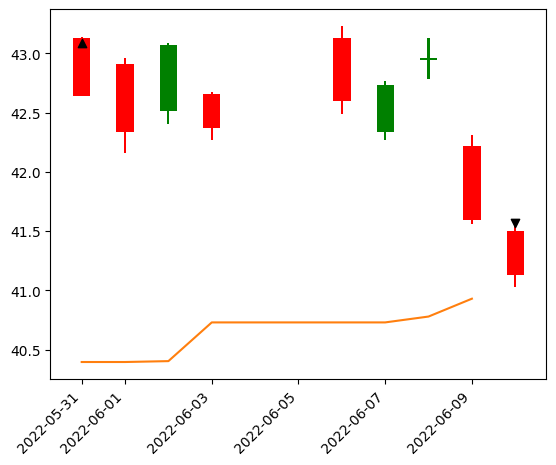

trade 145
entry: [40.150001525878906]
cost_basis: 40.150001525878906
exit: 39.959999084472656
returns: -0.00473231467460301
10


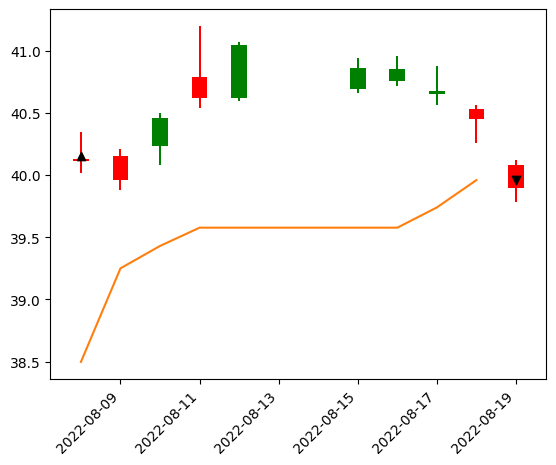

trade 146
entry: [35.650001525878906]
cost_basis: 35.650001525878906
exit: 38.59000015258789
returns: 0.08246840114648502
28


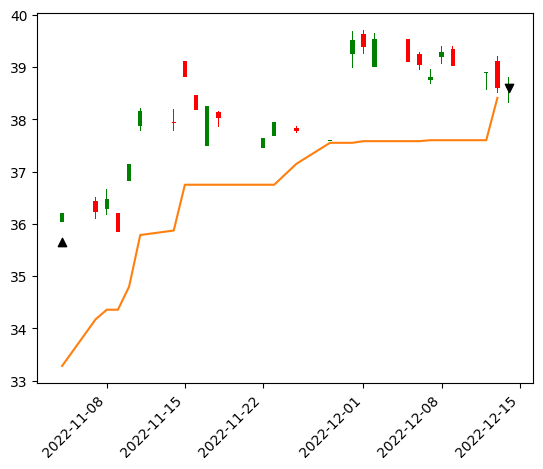

trade 147
entry: [39.27999877929688]
cost_basis: 39.27999877929688
exit: 41.36000061035156
returns: 0.05295320508388042
22


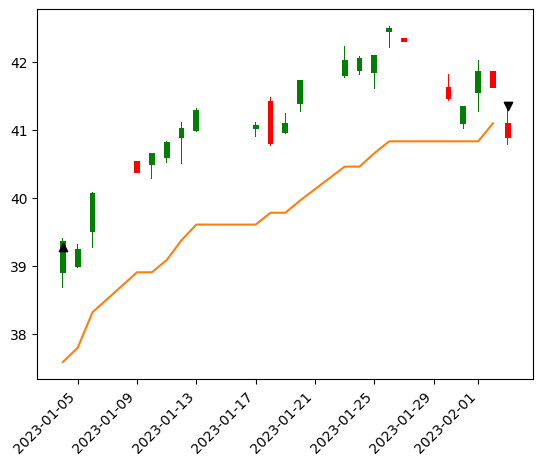

trade 148
entry: [39.540000915527344]
cost_basis: 39.540000915527344
exit: 39.380001068115234
returns: -0.004046531201502261
16


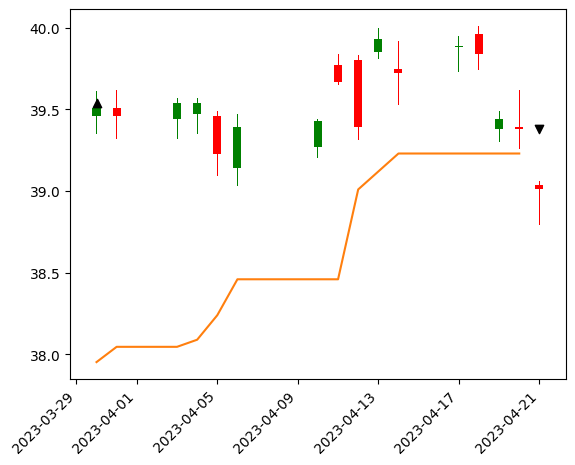

trade 149
entry: [39.40999984741211]
cost_basis: 39.40999984741211
exit: 38.54999923706055
returns: -0.02182188819287791
3


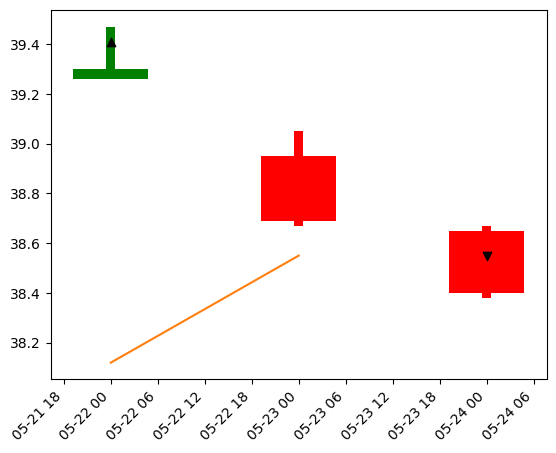

In [390]:
def plot_candle(df, show=False):
    #define width of candlestick elements
    width = .4
    width2 = .05

    #define up and down t.df
    up = df[df.close>=df.open].copy()
    down = df[df.close<df.open].copy()

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    #plot up t.df
    plt.bar(up.index,up.close-up.open,width,bottom=up.open,color=col1)
    plt.bar(up.index,up.high-up.close,width2,bottom=up.close,color=col1)
    plt.bar(up.index,up.low-up.open,width2,bottom=up.open,color=col1)

    #plot down t.df
    plt.bar(down.index,down.close-down.open,width,bottom=down.open,color=col2)
    plt.bar(down.index,down.high-down.open,width2,bottom=down.open,color=col2)
    plt.bar(down.index,down.low-down.close,width2,bottom=down.close,color=col2)

    #rotate x-axis tick labels
    plt.xticks(rotation=45, ha='right')

    if show:
        #display candlestick chart
        plt.show()


for i in range(len(tl.list)):
    t = tl.list[i]

    print(f'trade {i}')
    print(f'entry: {t.entry_price}')
    print(f'cost_basis: {t.cost_basis}')
    print(f'exit: {t.exit_price}')
    print(f'returns: {t.returns}')
    
    
    plot_candle(t.df)
    print(len(t.df))
    
    
    plt.plot(t.df['stop_loss'], color='C1')
    plt.scatter(t.df.index, t.df['entry_price'], marker='^', color='black')
    plt.scatter(t.df.index, t.df['exit_price'], marker='v', color='black')
    plt.show()



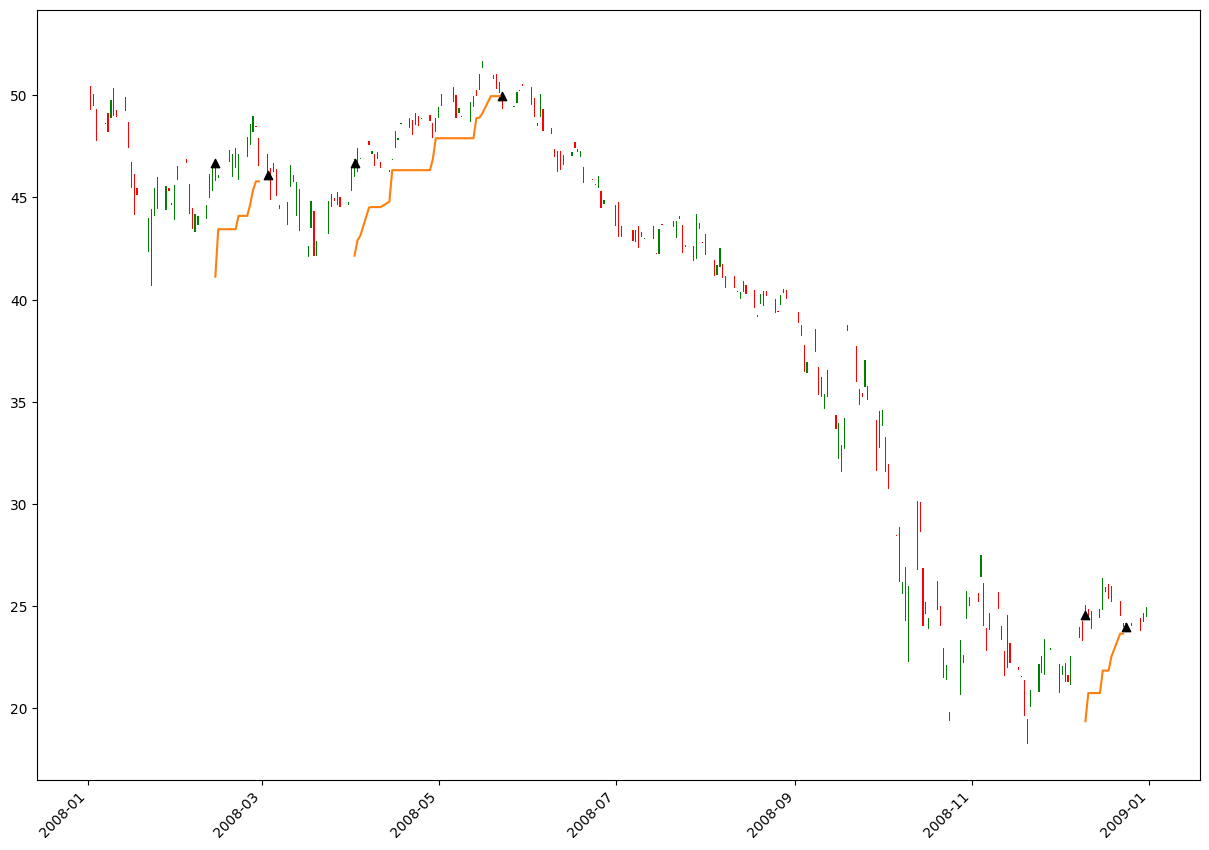

In [391]:
import datetime as dt
mask = (df.index >= pd.to_datetime(dt.date(2008, 1, 1))) & (df.index <= pd.to_datetime(dt.date(2009, 1, 1)))
df1 = df.loc[mask]
    
plt.figure(figsize=(15,10)) 
plot_candle(df1)

plt.plot(df1['stop_loss'], color='C1')
plt.scatter(df1.index, df1['entry_price'], marker='^', color='black')
plt.scatter(df1.index, df1['exit_price'], marker='^', color='black')
plt.show()

<Axes: >

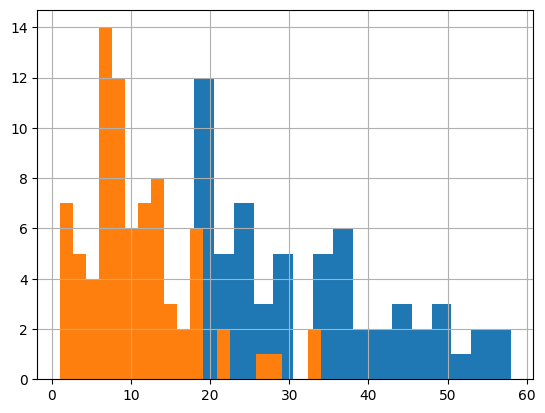

In [392]:
tl.win_records['time_in_trade'].hist(bins=20)
tl.loss_records['time_in_trade'].hist(bins=20)

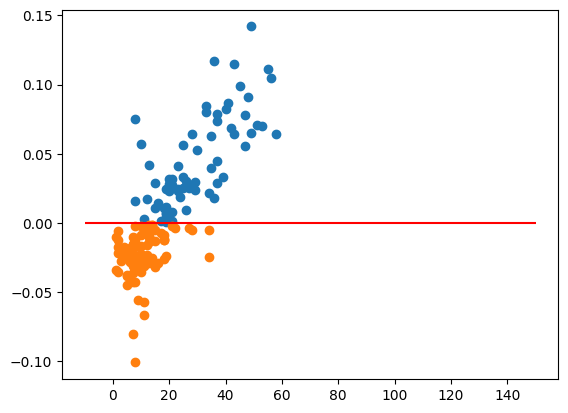

In [393]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'])
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')